In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

data_dir = './Data'

import cv2
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import time
from datetime import datetime
import os
import math
import random as rand
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plot
#from utils.data_utils import *
from vis_utils import visualize_grid, view_images, plot_images
from tensorflow.contrib.layers import batch_norm, flatten
from tensorflow.contrib.framework import arg_scope
import resnet
import dense_net
import spatial_transfrom
import SEnet
import pickle
import gc
import csv
from glob import glob

TF<1.2 support will be removed in the future!
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
#Define Hyper-paramenters
#display_step = 1
learningRate = 0.006
batch_size = 512
epochs = 400
#num_epochs = 50
momentum = 0.9
num_residual_blocks = 32
num_residual_blocks_loc = 5
require_improvement = 1000
weight_decay = 0.0002
n_split = 2
keep_probability = 0.8
keep_probability_loc1 = 0.8
keep_probability_loc2 = 0.8

best_validation_accuracy = 0.0

H, W, C = 64, 64, 3
image_shape = (H, W, C)
image_flat_shape = H * W * C
num_classes = 120
classes_mask = 0
real_class = num_classes - classes_mask

with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, H, W, C], name='x')
    y = tf.placeholder(tf.int32, [None, real_class], name='y')
    keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')

In [3]:
def _process_and_save(normalize, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = features
    labels = labels
    f = open(filename, 'wb')
    pickle.dump((features, labels), f)
    f.close()
    


def preprocess_save_data(loadFiles, normalize):
    """
    Preprocess Training and Validation Data
    """
    valid_features = []
    valid_labels = []
    features, labels, test_feature, test_labels, val_features, val_labels = loadFiles(sample_rate = 2)
    
    total_ = features.shape[0]
    split_num = int(total_ / n_split)
    print('features shape :{}, testFeature shape {}'.format(features.shape, test_feature.shape))
    print('split_num:{}'.format(split_num))
    for n in range(n_split):
        if n < n_split-1:
            _process_and_save(normalize, features[n * split_num: n * split_num + split_num - 1], 
                              labels[n * split_num: n * split_num + split_num - 1], 'preprocess_batch_trainning_{}.p'.format(n))
        else:
            _process_and_save(normalize, features[n * split_num: -1], 
                              labels[n * split_num: -1], 'preprocess_batch_trainning_{}.p'.format(n))
        
    _process_and_save(normalize, test_feature, test_labels, 'preprocess_batch_testing.p')
    _process_and_save(normalize, val_features, val_labels, 'preprocess_batch_val.p')


def SplitData(data, rate=0.2):
    cuttendDataCount = int(data.shape[0] * rate)
    group1 = [] 
    group2 = []
    for i in range(len(data)):
        if i < cuttendDataCount:
            group2.append(data[i])
        else:
            group1.append(data[i])
            
    return np.array(group1), np.array(group2)

In [4]:
def BatchingData(batch_size, X_train, Y_train, trainBatchCount):
    """
    Process batching data
    """
    for i in range(trainBatchCount):
        start_t = i*batch_size
        #print(X_train.shape)
        X_t_batch = np.cast['float'](X_train[start_t:start_t+batch_size])
        Y_t_batch = np.cast['float'](Y_train[start_t:start_t+batch_size])
        
        yield X_t_batch, Y_t_batch, i
    X_t_batch, Y_t_batch = None, None


def SelectSetFromBatchSet(Batch_size, Data1, Data2):
    ids = np.arange(Data1.shape[0])
    rand.shuffle(ids)
    rand.shuffle(ids)
    X_ = []
    Y_ = []
    for i in range(batch_size):
        X_.append(Data1[ids[i]])
        Y_.append(Data2[ids[i]])
    return X_, Y_

In [35]:
a1 = [a[2] for a in os.walk('./Data/postTest/')]
a1

[['000621fb3cbb32d8935728e48679680e.jpg',
  '00102ee9d8eb90812350685311fe5890.jpg',
  '0012a730dfa437f5f3613fb75efcd4ce.jpg',
  '001510bc8570bbeee98c8d80c8a95ec1.jpg',
  '001a5f3114548acdefa3d4da05474c2e.jpg',
  '00225dcd3e4d2410dd53239f95c0352f.jpg',
  '002c2a3117c2193b4d26400ce431eebd.jpg',
  '002c58d413a521ae8d1a5daeb35fc803.jpg',
  '002f80396f1e3db687c5932d7978b196.jpg',
  '0036c6bcec6031be9e62a257b1c3c442.jpg',
  '0041940322116ae58c38130f5a6f71f9.jpg',
  '0042d6bf3e5f3700865886db32689436.jpg',
  '004476c96f575879af4af471af65cae8.jpg',
  '00485d47de966a9437ad3b33ac193b6f.jpg',
  '00496f65de6cc319145ce97bd6e90360.jpg',
  '004bf14426d1a830d459a9e0c0721309.jpg',
  '004c3721eb88358f462cdcec6b2380b7.jpg',
  '00559f56aab7e0a7749220f6aed65162.jpg',
  '005b281f1a4d6f29d527c9585e9bd33c.jpg',
  '005b6c6c76fefd6b458ef6fb6e54da6e.jpg',
  '006870b49353779b25eeb91fed43c31a.jpg',
  '0068f3a21b159ece126a28580cdad7a0.jpg',
  '0069b1cc4546fc98f84f981bf9a0696a.jpg',
  '0077bc3c63486ff09d3774d956af8f7

In [ ]:
import glob
sub_dirs = [x[0] for x in os.walk('./Data/Standford/Images')]

is_root_dir = True
file_list = []
for sub_dir in sub_dirs:
    if is_root_dir:
        is_root_dir = False
        continue
    
    extensions = ['jpg', 'jpeg']
    dir_name = os.path.basename(sub_dir)
    
    for extension in extensions:
        file_glob = os.path.join('./Data/Standford/Images/', dir_name, '*.'+extension)
        files = glob.glob(file_glob)
        #print(len(files))
        file_list.extend(files)
        for file in files:
            print(file)
print('file_list length {}'.format(len(file_list)))
#print(file_list)

./Data/Standford/Images/n02085620-Chihuahua\n02085620_10074.jpg
./Data/Standford/Images/n02085620-Chihuahua\n02085620_10131.jpg
./Data/Standford/Images/n02085620-Chihuahua\n02085620_10621.jpg
./Data/Standford/Images/n02085620-Chihuahua\n02085620_1073.jpg
./Data/Standford/Images/n02085620-Chihuahua\n02085620_10976.jpg
./Data/Standford/Images/n02085620-Chihuahua\n02085620_11140.jpg
./Data/Standford/Images/n02085620-Chihuahua\n02085620_11238.jpg
./Data/Standford/Images/n02085620-Chihuahua\n02085620_11258.jpg
./Data/Standford/Images/n02085620-Chihuahua\n02085620_11337.jpg
./Data/Standford/Images/n02085620-Chihuahua\n02085620_11477.jpg
./Data/Standford/Images/n02085620-Chihuahua\n02085620_1152.jpg
./Data/Standford/Images/n02085620-Chihuahua\n02085620_11696.jpg
./Data/Standford/Images/n02085620-Chihuahua\n02085620_11818.jpg
./Data/Standford/Images/n02085620-Chihuahua\n02085620_11948.jpg
./Data/Standford/Images/n02085620-Chihuahua\n02085620_1205.jpg
./Data/Standford/Images/n02085620-Chihuahua

In [5]:
def Label_OneHot(count, n_class, y_val):
    y = []
    for i in range(count):
        y.append(np.eye(n_class, dtype='int32')[y_val])
    return y

def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    a = 0
    b = 255
    return (x-a)/(b-a)

def file_name(file_dir, fileCount):
    num = 0
    for root, dirs, files in os.walk(file_dir):
        fileCount[0] = len(files)
        for file in files:
            if os.path.splitext(file)[1] == '.jpg' or os.path.splitext(file)[1] == '.JPG':
                p = os.path.join(root, file)
                n = os.path.splitext(file)[0]
                num = num +1
                yield p, n, num


In [6]:
X_val, Y_val = None, None
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    X_val, Y_val = pickle.load(open('./preprocess_batch_val.p', mode='rb'))
    miner_val_x = X_val
    miner_val_y = Y_val
       
    
    istart = rand.randint(0, miner_val_x.shape[0] - 5)
    iend = istart+4
    print('test random sample at {}, {}'.format(istart, iend))
    view_images(miner_val_x[istart:iend])
    _dcoded = OnehotDecode(miner_val_y[istart:iend])
    for lab_ in _dcoded:
        print('index:{}, name: {}, split data count: {}'.format(lab_, Lstrings[int(lab_)], trainBatchCount))
                
    loss = session.run(cost, feed_dict={x:miner_val_x, y:miner_val_y, keep_prob:1.0, learning_rate:learningRate})
    valid_acc = sess.run(accuracy, feed_dict={
                    x: miner_val_x,
                    y: miner_val_y,
                    keep_prob: 1.,
                    learning_rate:learningRate
    })
    
    print('Validation Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(
                    loss,
                    valid_acc))
    return loss, valid_acc

In [25]:
def center_crop(img):
    shape = img.shape
    h = shape[0]
    w = shape[1]
    c = shape[2]
    if w > h:
        lbound = int(math.ceil(w - h) / 2)
        rbound = w - lbound
        return img[:, lbound:rbound, :]
    else:
        tbound = int(math.ceil(h - w) / 2)
        bbound = h - tbound
        return img[tbound:bbound, :, :]

    
def LoadDataImages(subModule, sample_rate=1):
    _x_ = {}
    fileCount = [0]
    for path, name, num in file_name(os.path.join(data_dir, subModule), fileCount):
        #print(fileCount[0])
        if num > int(fileCount[0] * sample_rate):
            break
        pImg = Image.open(path)
        if pImg.width > pImg.height:
            newWeight = int(pImg.size[0] * (H / pImg.size[1]))
            newHeight = H
        else:
            newHeight = int(pImg.size[1] * (W / pImg.size[0]))
            newWeight = W
        pImg = pImg.resize((newWeight,newHeight))
        pImg = center_crop(np.array(pImg))
        pImg = Image.fromarray(pImg, mode='RGB').resize((H,W))
        
        #print('pImg size:{}'.format(pImg.shape)
        _x_[name] = pImg
        
    print('final load data count {}'.format(num))
    return _x_

def OnehotDecode(y):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(real_class))
    label_ids = label_binarizer.inverse_transform(y)
    return label_ids

Lstrings = []
def LoadDataLebels():
    labels={}
    rawLabels = {}
    with open('./labels.csv', 'r') as lab:
        reader = csv.reader(lab)
        #print(reader[0])
        for row in reader:
            if row[1] == 'breed':
                continue
                
            val = 0
            if row[1] in Lstrings:
                val = Lstrings.index(row[1])
            else:
                val = len(Lstrings)
                Lstrings.append(row[1])
            
            if val  < real_class:
                labels[row[0]] = np.eye(real_class, dtype='int32')[val]
                rawLabels[row[0]] = val
    
    #print(len(Lstrings))
    #print(Lstrings)
    return labels, rawLabels

def Label_mask(keys, rawLab):
    keyCollect = []
    for key, val in rawLab.items():
        if val < real_class and key in keys:
            keyCollect.append(key)
    return keyCollect

    
def resort_keys(keys, rawLab):
    keyCollect = {}
    for key, val in rawLab.items():
        if key in keys:
            if val in keyCollect.keys():
                keyCollect[val].append(key)
            else:
                keyCollect[val] = [key]
    #print(len(keyCollect.keys()))
    for key in keyCollect.keys():
        value_ = keyCollect[key]
        keyCollect[key] = iter(value_)
    keyIdx = [i % num_classes for i in range(len(keys))]
    #print(keyIdx[:130])
    sortedKey = []
    for idx in keyIdx:
        sortedKey.append(keyNext(keyCollect, idx))
    #print(len(sortedKey))
    #print((sortedKey[:130]))
    return sortedKey
    
def keyNext(collection, idx):
    val = ''
    #print('keyNext idx:{}'.format(idx))
    try:
        val = next(collection[idx])
    except Exception as e:
        idx += 1
        if idx >= 120:
            idx = 0
        val = keyNext(collection, idx)
    if val != '':
        return val

def load_preprocess_batch(subModule, batch_size, dataCount):
    features, labels = None, None
    gc.collect()
    features, labels = pickle.load(open('./'+subModule+'.p', mode='rb'))
    trainBatchCount = int(features.shape[0] / batch_size)
    dataCount[0] = trainBatchCount
    print(subModule)
    
    return BatchingData(batch_size, features, labels, trainBatchCount)

#labels = LoadDataLebels()
#len(labels)
#print('{}, {}, {}, {}'.format(labels['fc64ecf1ef29b56646e2480196877f7b'], labels['00a338a92e4e7bf543340dc849230e75'], 
                            #labels['0f5dd4999e44100d74f68c789f3edc54'], labels['00cc68a50b2d016a6b29af628ea4e04b']))
#TrainData = LoadDataImages('train')
#print(len(TrainData))

In [8]:
#view_images(np.array([TrainData['fc64ecf1ef29b56646e2480196877f7b'], TrainData['00a338a92e4e7bf543340dc849230e75'], TrainData['0f5dd4999e44100d74f68c789f3edc54'], TrainData['00cc68a50b2d016a6b29af628ea4e04b']]))

In [30]:


def SaveDataIntoFolder():
    TrainData = LoadDataImages('train', 1)
    Labels, rawLab = LoadDataLebels()
    keys = [key for key in TrainData.keys()]
    
    keyCollect = {}
    for key1, val in rawLab.items():
        if key1 in keys:
            if val in keyCollect.keys():
                keyCollect[val].append(key1)
            else:
                keyCollect[val] = [key1]
    print(len(keyCollect))
    for key2 in keyCollect.keys():
        value_ = keyCollect[key2]
        print(len(value_))
        if os.path.exists('./Data/trains2/'+str(Lstrings[key2])) == False:
            os.makedirs('./Data/trains2/'+str(Lstrings[key2]))
            
        for hashs in value_:
            TrainData[hashs].save(os.path.join('./Data/trains2/'+str(Lstrings[key2]), hashs+'.jpg'))
            
            
SaveDataIntoFolder()

final load data count 10222
120
87
80
75
85
67
89
75
110
126
76
69
117
83
86
82
72
99
75
74
69
72
78
77
106
80
84
91
83
85
69
82
76
80
91
107
95
112
82
71
69
82
82
102
86
88
88
78
85
109
78
73
86
96
72
115
87
81
79
71
99
94
73
67
107
106
80
75
114
74
90
76
92
80
82
116
87
84
102
66
101
67
79
93
72
78
71
79
86
81
95
91
66
83
89
111
105
70
81
82
95
88
79
81
105
79
111
72
82
92
75
102
90
78
75
70
86
69
75
74
76


In [9]:
labels, rawLab = LoadDataLebels()
#keys = [key for key in rawLab.keys()]
#Label_mask(keys, rawLab)
#print('{}, {}, {}, {}'.format(labels['fc64ecf1ef29b56646e2480196877f7b'], labels['00a338a92e4e7bf543340dc849230e75'], labels['0f5dd4999e44100d74f68c789f3edc54'], labels['00cc68a50b2d016a6b29af628ea4e04b']))

In [10]:

def PreProcessTrainData(sample_rate = 1):
    TrainData = LoadDataImages('postTrain', sample_rate)
    Labels, rawLab = LoadDataLebels()
    
    keys = [key for key in TrainData.keys()]
    #rand.shuffle(keys)
    sortKey = Label_mask(keys, rawLab)
    keysTrain, keysTest = SplitData(np.array(sortKey))
    keysTrain, keysVal = SplitData(keysTrain)
    print("get key shape {}, {}, {}".format(keysTrain.shape, keysTest.shape, keysVal.shape))
    trainingImg, trainningLabel = [], []
    rand.shuffle(keysTrain)
    for key in keysTrain:
        print('TrainData[Key] : {}'.format(TrainData[key].shape))
        trainingImg.append(TrainData[key])
        trainningLabel.append(Labels[key])
    
    testImg, testLabel = [], []
    rand.shuffle(keysTest)
    for key in keysTest:
        testImg.append(TrainData[key])
        testLabel.append(Labels[key])
        
    valImg, valLabel = [], []
    rand.shuffle(keysVal)
    for key in keysVal:
        valImg.append(TrainData[key])
        valLabel.append(Labels[key])
    
    
    print ('finish processing image with shapes: {}, {}, {}, {}, {}, {}'.format(len(trainingImg), len(trainningLabel), 
                                                                                len(testImg), len(testLabel), 
                                                                                len(valImg), len(valLabel)))
    
    return np.array(trainingImg), np.array(trainningLabel), np.array(testImg), np.array(testLabel), np.array(valImg), np.array(valLabel)


In [11]:
#preprocess_save_data(PreProcessTrainData, normalize)

In [12]:
def loss(logits, labels):
    labels = tf.cast(labels, tf.int64)
    print(logits.get_shape().as_list())
    print(labels.get_shape().as_list())
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels, name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    return cross_entropy_mean

def train_operation(global_step, total_loss):
    opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = opt.minimize(total_loss, global_step=global_step)
    return train_op

In [13]:

def loadImgsAndSave():
    _x_ = LoadDataImages('postTest', 1)
    paths = []
    print('X len is {}'.format(len(_x_)))
    f = open('test_set.p', 'wb')
    pickle.dump((_x_), f)
    f.close()
    
def loadImgs():
    result = {}
    f = open('test_set.p', mode='rb')
    data_loaded = pickle.load(f)
    f.close()
    print(len(data_loaded))
    result['path'] = np.array([key for key in data_loaded.keys()])
    result['data'] = np.array([value for value in data_loaded.values()])
    return result

In [14]:
#path, num = file_name(os.path.join(data_dir, 'postTest'))
#print(num)
#loadImgsAndSave()

In [15]:
from tensorpack.train.base import *

global_step = tf.Variable(0, trainable=False)
validation_step = tf.Variable(0, trainable=False)
with tf.name_scope('Summaries'):
    logits = dense_net.Dense_net('DenseNet', x, real_class, num_residual_blocks)
    
    train_loss = loss(logits, y)
    
    #l2_loss = tf.add_n([tf.nn.l2_loss(var) for var in tf.trainable_variables()])
    
    regu_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    
    full_loss = tf.add_n([train_loss] + regu_losses, name='full_loss')
    
    tf.summary.scalar('Full_loss', full_loss)
    
    train_op = train_operation(global_step, full_loss)
    
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    
    tf.summary.scalar('accuracy', accuracy)  

[1223 04:53:59 @registry.py:121] conv0_DenseNet input: [None, 64, 64, 3]
[1223 04:53:59 @registry.py:129] conv0_DenseNet output: [None, 64, 64, 16]
[1223 04:53:59 @registry.py:121] block1_DenseNet/dense_layer.0/conv1 input: [None, 64, 64, 3]
[1223 04:53:59 @registry.py:129] block1_DenseNet/dense_layer.0/conv1 output: [None, 64, 64, 12]
[1223 04:53:59 @registry.py:121] block1_DenseNet/dense_layer.1/conv1 input: [None, 64, 64, 3]
[1223 04:53:59 @registry.py:129] block1_DenseNet/dense_layer.1/conv1 output: [None, 64, 64, 12]
[1223 04:53:59 @registry.py:121] block1_DenseNet/dense_layer.2/conv1 input: [None, 64, 64, 3]
[1223 04:53:59 @registry.py:129] block1_DenseNet/dense_layer.2/conv1 output: [None, 64, 64, 12]
[1223 04:53:59 @registry.py:121] block1_DenseNet/dense_layer.3/conv1 input: [None, 64, 64, 3]
[1223 04:53:59 @registry.py:129] block1_DenseNet/dense_layer.3/conv1 output: [None, 64, 64, 12]
[1223 04:54:00 @registry.py:121] block1_DenseNet/dense_layer.4/conv1 input: [None, 64, 64, 3

In [16]:
xx = None
def saveOutput(sess, number):
    xx = loadImgs()
    print(xx['data'].shape)
    
    path__ = []
    ww = rand.randint(1, 25)
    batch_count = int(xx['data'].shape[0]/batch_size)
    
    dataCount = [0]
    test_total_acc = 0
    for feature, labels, batch_i in  load_preprocess_batch('preprocess_batch_testing', batch_size, dataCount):
        test_total_acc += sess.run(accuracy, feed_dict={x:feature, y:labels, keep_prob:1., learning_rate:learningRate})
        
    print("the batch at {}, local acc is {}".format(batch_i, test_total_acc))
    
    text_=''
    __text = ''
    _text_ = ''
    for _x_, _y_, batch_i in BatchingData(batch_size, xx['data'], np.array(Label_OneHot(10357, ww)), batch_count):
        __x = normalize(_x_)
        predictions  = sess.run(logits, feed_dict={x:__x, keep_prob:1.})
        random_test_predictions  = sess.run(tf.nn.top_k(tf.nn.softmax(logits), 30), feed_dict={x:__x,  keep_prob:1., learning_rate:learningRate})
        
        label_binarizer = LabelBinarizer()
        label_binarizer.fit(range(30))
        label_ids = label_binarizer.inverse_transform(predictions)
        
        print('label_ids shape{},test_predictions shape {}'.format(label_ids.shape, random_test_predictions.values.shape))
        
        for idx in range(batch_size):
            _text_ += '{}, {}, {}, {}\n'.format(xx['path'][idx + (batch_i * batch_size)], 
                                           random_test_predictions.indices[idx][0], random_test_predictions.values[idx][0], label_ids[idx])
            
            for idxx in range(30):
                __text += '{}, {}, {:.15f}\n'.format(xx['path'][idx + (batch_i * batch_size)], 
                                           random_test_predictions.indices[idx][idxx]+1, random_test_predictions.values[idx][idxx])
            
            if idx % 5 == 0:
                text_ += 'filename : {}, Label: {}, Prediction: {}\n'.format(xx['path'][idx + (batch_i * batch_size)], 
                                           label_ids[idx], random_test_predictions.values[idx][:3])
                #print(text_)
            #text_ += '\n'

        #print(text_)
        
       
        path__ = []
    
    #print(__text[0:200])
    save_model_path = './NoTran_test_{}'.format(number)
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)
    
    f2 = open('./output_{}.csv'.format(number), 'w')
    f2.write(__text)
    f2.close()
    f1=open('./output_{}.log'.format(number), 'w')
    f1.write(text_)
    f1.close()
    f3 = open('./output_d_{}.csv'.format(number), 'w')
    f3.write(_text_)
    f3.close()

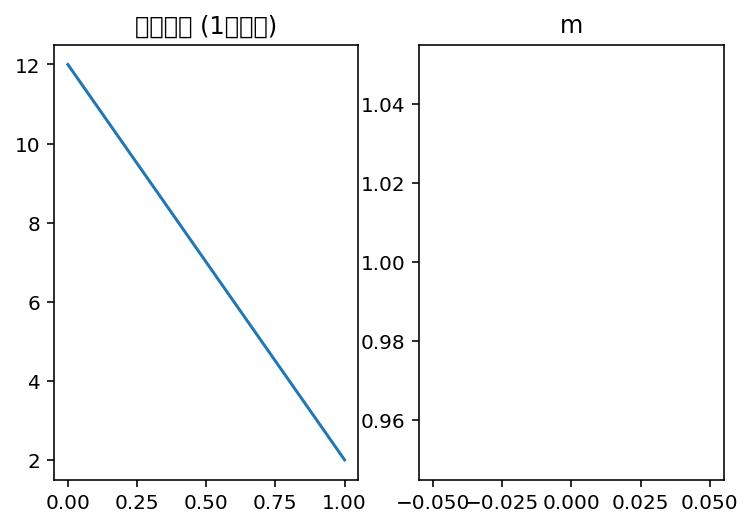

In [17]:
i = [12, 2];m=1
plot.subplot2grid((1,2),(0,0))
plot.title(u"获救情况 (1为获救)") # 标题
plot.plot(i)


plot.subplot2grid((1,2),(0,1))
plot.title(u"m") # 标题
plot.plot(m)

random sample at 316, 320


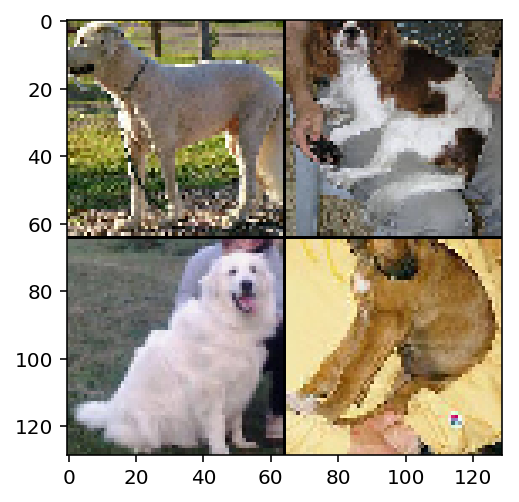

index:94, name: great_pyrenees, split data count: 6
index:110, name: blenheim_spaniel, split data count: 6
index:94, name: great_pyrenees, split data count: 6
index:44, name: rhodesian_ridgeback, split data count: 6
Trainning sub batch 1/6 in local loss is 4.8084
random sample at 60, 64


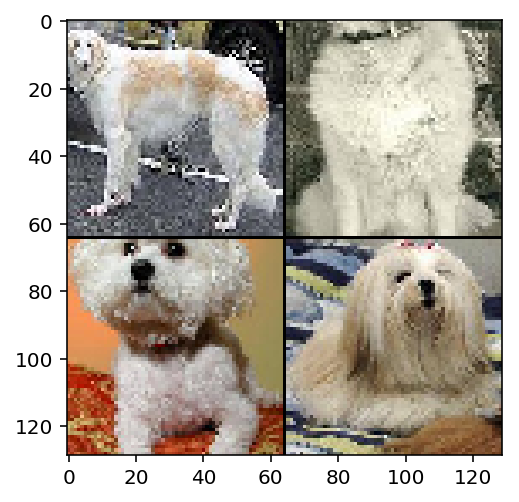

index:6, name: borzoi, split data count: 6
index:94, name: great_pyrenees, split data count: 6
index:36, name: shih-tzu, split data count: 6
index:69, name: lhasa, split data count: 6
Trainning sub batch 1/6 in local loss is 4.7810
Split summary: Trainning 2/2  in epoch 1, local loss is 4.7536
test random sample at 1067, 1071


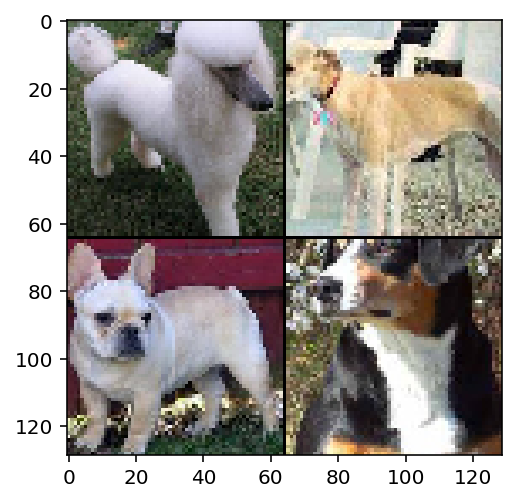

index:101, name: standard_poodle, split data count: 6
index:99, name: whippet, split data count: 6
index:114, name: french_bulldog, split data count: 6
index:54, name: entlebucher, split data count: 6
Validation Loss:     4.7710 Validation Accuracy: 0.018566


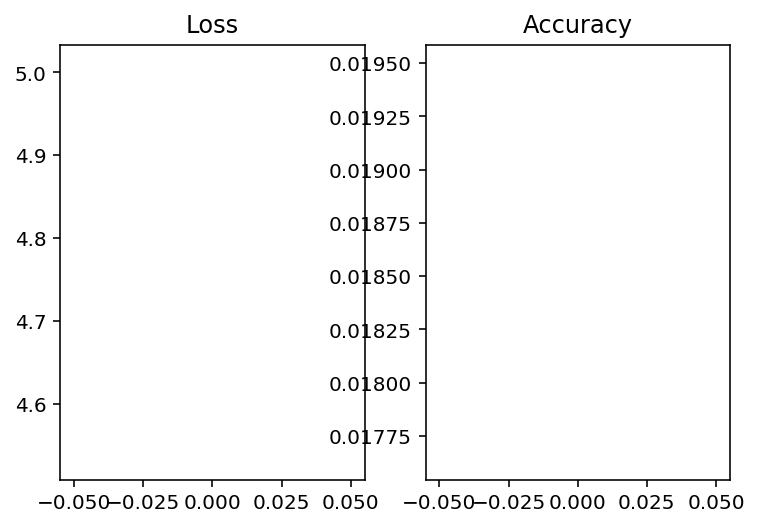

epoch Summary: 2017-12-23 04:54:37.569594: loss = 4.7536 (73.9 examples/sec; 6.925 sec/batch)
----------------------------
random sample at 125, 129


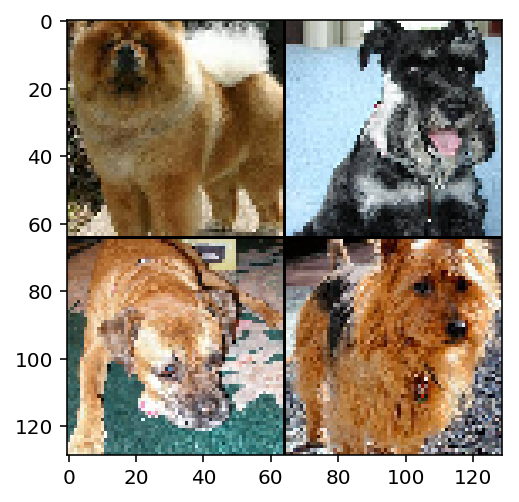

index:82, name: chow, split data count: 6
index:49, name: miniature_schnauzer, split data count: 6
index:17, name: boxer, split data count: 6
index:42, name: australian_terrier, split data count: 6
Trainning sub batch 1/6 in local loss is 4.7401
random sample at 114, 118


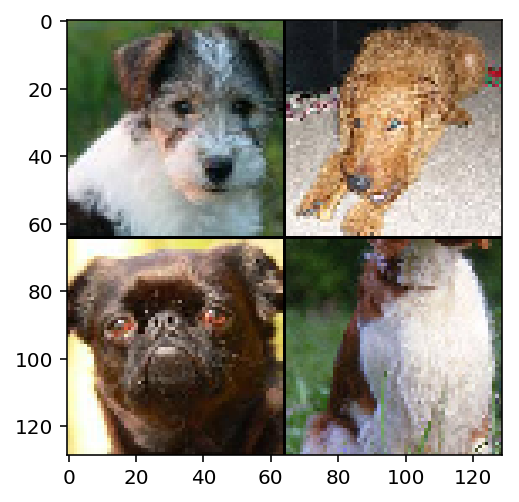

index:14, name: wire-haired_fox_terrier, split data count: 6
index:37, name: irish_terrier, split data count: 6
index:80, name: brabancon_griffon, split data count: 6
index:57, name: welsh_springer_spaniel, split data count: 6
Trainning sub batch 1/6 in local loss is 4.7495
Split summary: Trainning 2/2  in epoch 2, local loss is 4.7119
test random sample at 317, 321


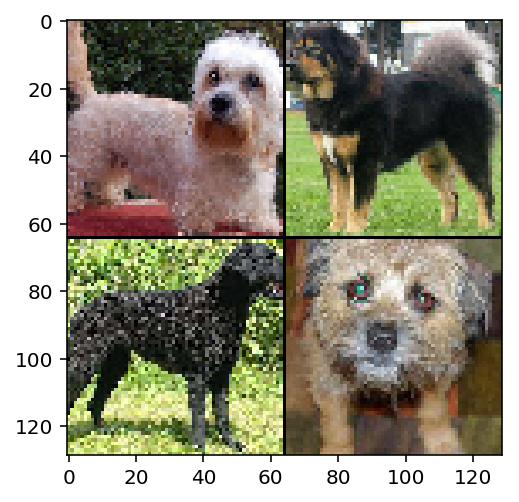

index:93, name: dandie_dinmont, split data count: 6
index:116, name: tibetan_mastiff, split data count: 6
index:106, name: curly-coated_retriever, split data count: 6
index:33, name: border_terrier, split data count: 6
Validation Loss:     4.7486 Validation Accuracy: 0.019206


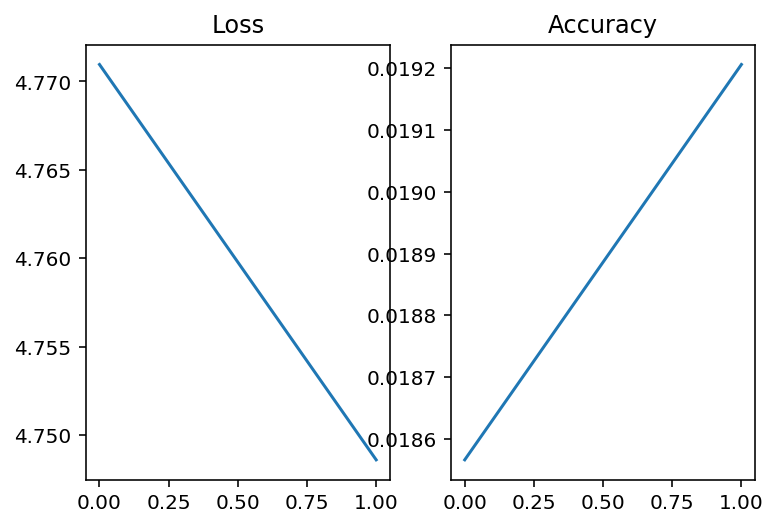

epoch Summary: 2017-12-23 04:54:41.978468: loss = 4.7119 (116.2 examples/sec; 4.405 sec/batch)
----------------------------
random sample at 0, 4


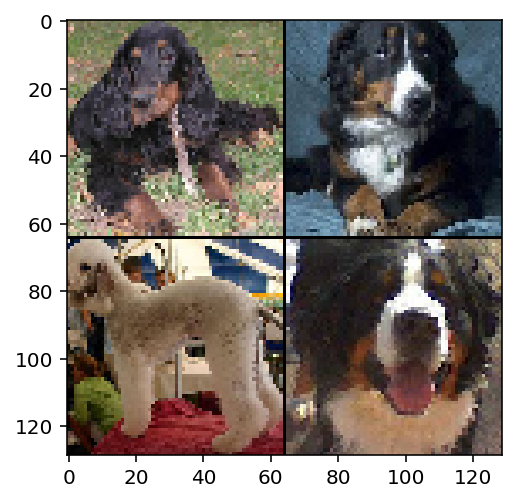

index:88, name: gordon_setter, split data count: 6
index:67, name: bernese_mountain_dog, split data count: 6
index:5, name: bedlington_terrier, split data count: 6
index:67, name: bernese_mountain_dog, split data count: 6
Trainning sub batch 1/6 in local loss is 4.7065
random sample at 427, 431


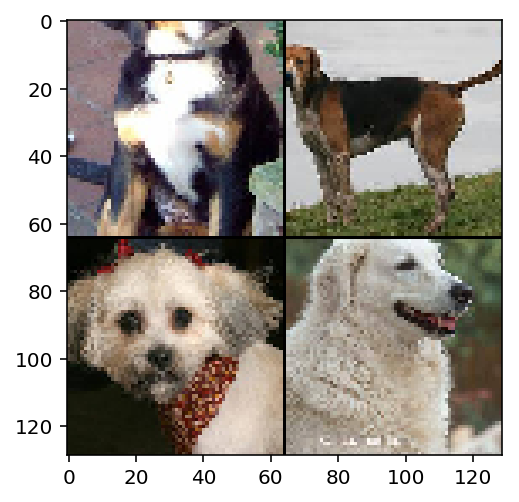

index:54, name: entlebucher, split data count: 6
index:87, name: english_foxhound, split data count: 6
index:69, name: lhasa, split data count: 6
index:38, name: kuvasz, split data count: 6
Trainning sub batch 1/6 in local loss is 4.7230
Split summary: Trainning 2/2  in epoch 3, local loss is 4.6667
test random sample at 342, 346


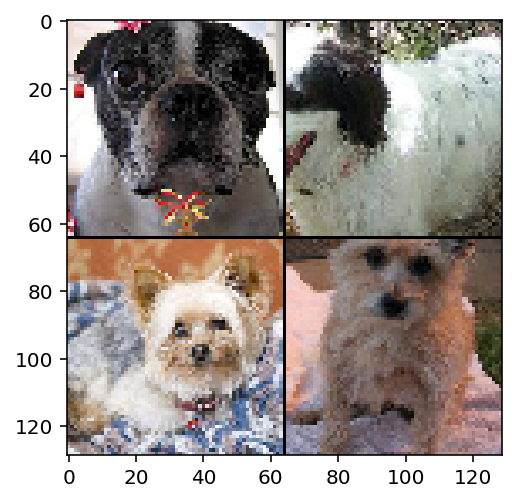

index:0, name: boston_bull, split data count: 6
index:27, name: english_setter, split data count: 6
index:107, name: yorkshire_terrier, split data count: 6
index:42, name: australian_terrier, split data count: 6
Validation Loss:     4.7201 Validation Accuracy: 0.025608


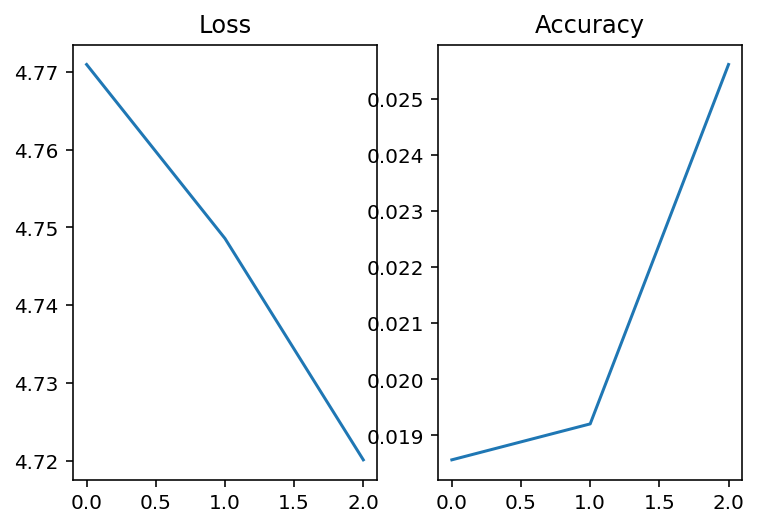

epoch Summary: 2017-12-23 04:54:46.357102: loss = 4.6667 (117.0 examples/sec; 4.375 sec/batch)
----------------------------
random sample at 268, 272


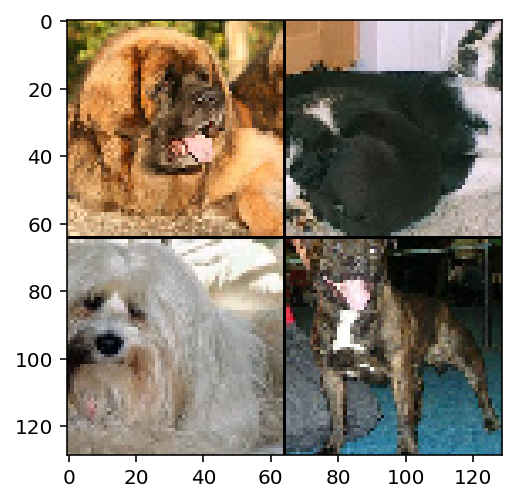

index:64, name: leonberg, split data count: 6
index:53, name: border_collie, split data count: 6
index:34, name: tibetan_terrier, split data count: 6
index:86, name: staffordshire_bullterrier, split data count: 6
Trainning sub batch 1/6 in local loss is 4.6683
random sample at 88, 92


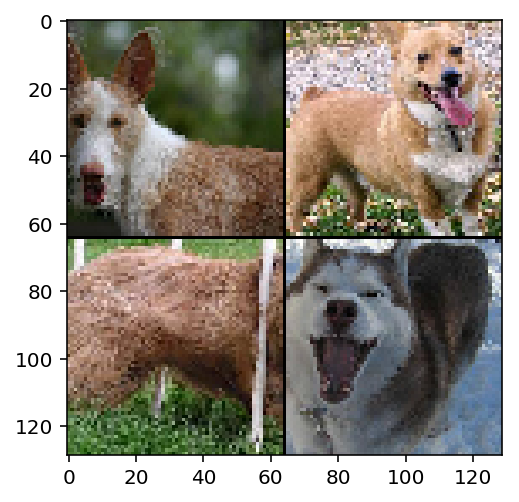

index:26, name: ibizan_hound, split data count: 6
index:108, name: pembroke, split data count: 6
index:91, name: briard, split data count: 6
index:89, name: siberian_husky, split data count: 6
Trainning sub batch 1/6 in local loss is 4.6887
Split summary: Trainning 2/2  in epoch 4, local loss is 4.6144
test random sample at 1450, 1454


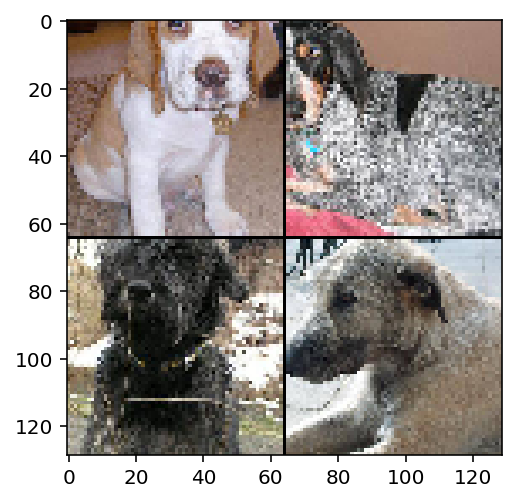

index:95, name: beagle, split data count: 6
index:3, name: bluetick, split data count: 6
index:29, name: giant_schnauzer, split data count: 6
index:79, name: irish_wolfhound, split data count: 6
Validation Loss:     4.6803 Validation Accuracy: 0.038412


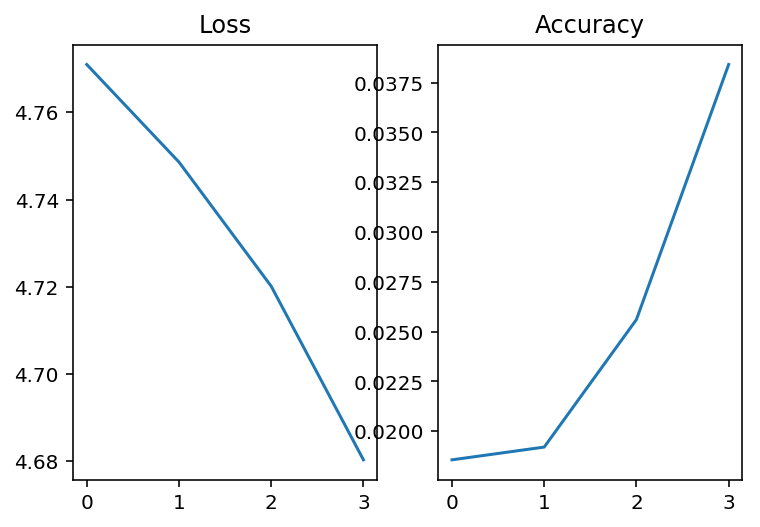

epoch Summary: 2017-12-23 04:54:50.778928: loss = 4.6144 (115.9 examples/sec; 4.418 sec/batch)
----------------------------
random sample at 189, 193


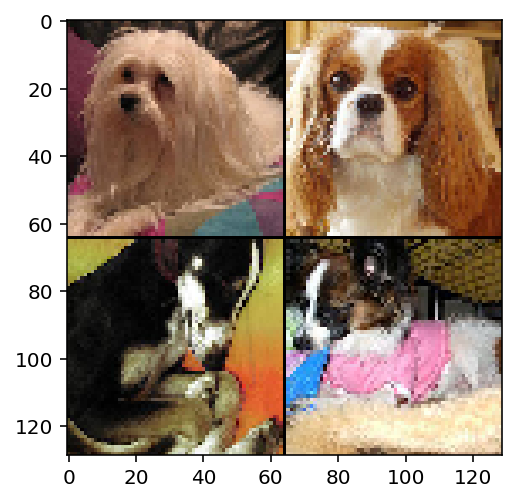

index:11, name: maltese_dog, split data count: 6
index:110, name: blenheim_spaniel, split data count: 6
index:99, name: whippet, split data count: 6
index:52, name: papillon, split data count: 6
Trainning sub batch 1/6 in local loss is 4.6195
random sample at 94, 98


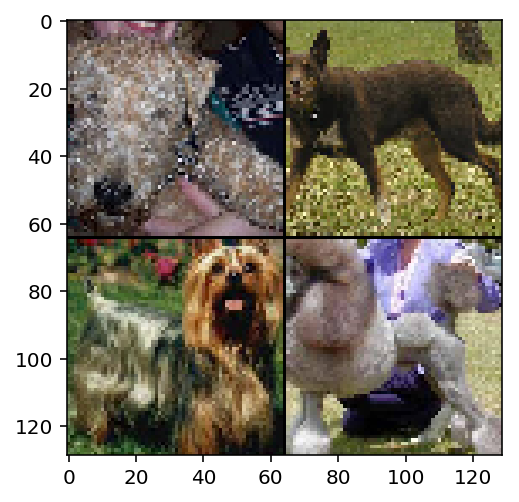

index:16, name: lakeland_terrier, split data count: 6
index:51, name: kelpie, split data count: 6
index:111, name: silky_terrier, split data count: 6
index:101, name: standard_poodle, split data count: 6
Trainning sub batch 1/6 in local loss is 4.6479
Split summary: Trainning 2/2  in epoch 5, local loss is 4.5633
test random sample at 53, 57


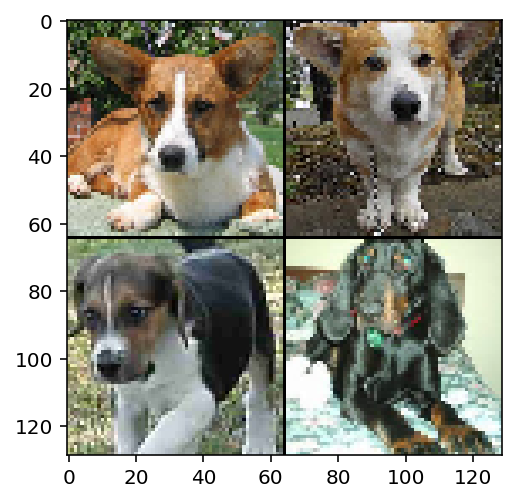

index:70, name: cardigan, split data count: 6
index:108, name: pembroke, split data count: 6
index:87, name: english_foxhound, split data count: 6
index:22, name: black-and-tan_coonhound, split data count: 6
Validation Loss:     4.6389 Validation Accuracy: 0.035211


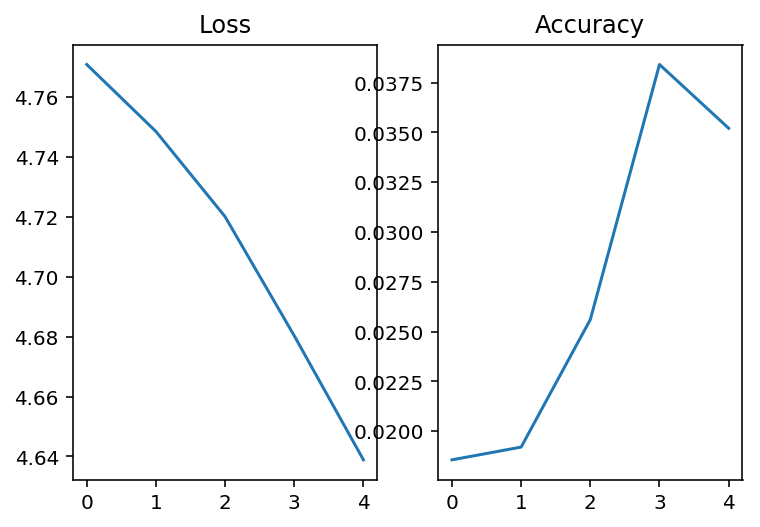

epoch Summary: 2017-12-23 04:54:55.279963: loss = 4.5633 (113.9 examples/sec; 4.497 sec/batch)
----------------------------
random sample at 405, 409


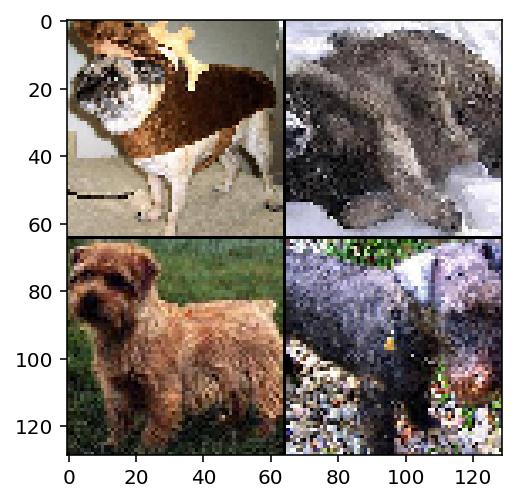

index:60, name: pug, split data count: 6
index:35, name: norwegian_elkhound, split data count: 6
index:12, name: norfolk_terrier, split data count: 6
index:16, name: lakeland_terrier, split data count: 6
Trainning sub batch 1/6 in local loss is 4.5677
random sample at 111, 115


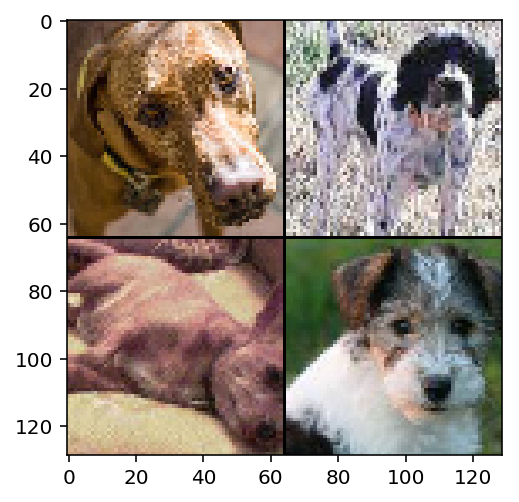

index:96, name: vizsla, split data count: 6
index:27, name: english_setter, split data count: 6
index:58, name: chihuahua, split data count: 6
index:14, name: wire-haired_fox_terrier, split data count: 6
Trainning sub batch 1/6 in local loss is 4.6071
Split summary: Trainning 2/2  in epoch 6, local loss is 4.5214
test random sample at 763, 767


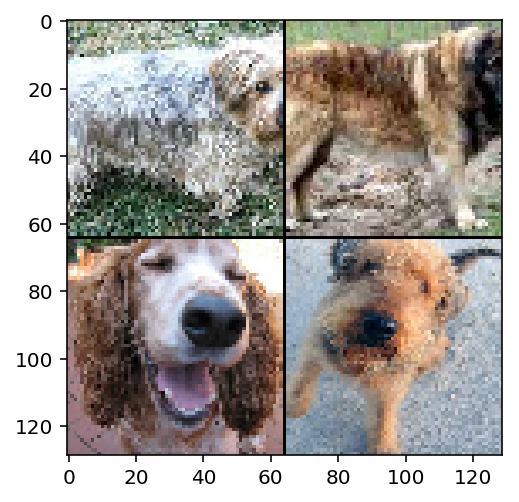

index:111, name: silky_terrier, split data count: 6
index:64, name: leonberg, split data count: 6
index:57, name: welsh_springer_spaniel, split data count: 6
index:63, name: airedale, split data count: 6
Validation Loss:     4.6013 Validation Accuracy: 0.032650


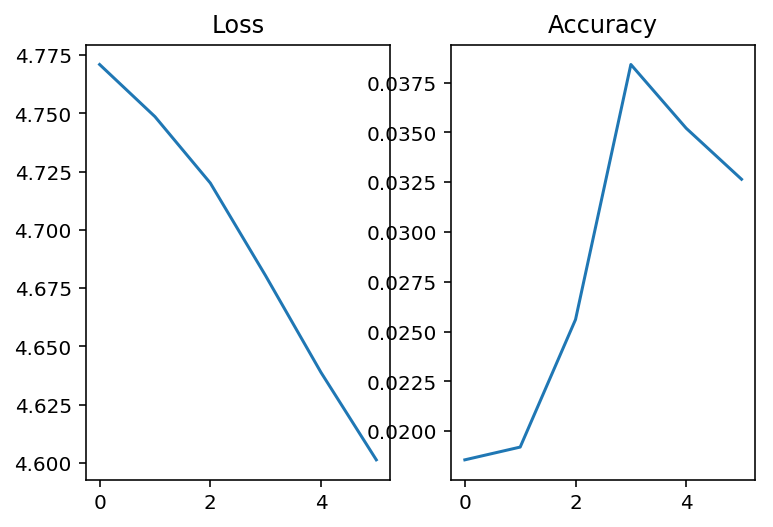

epoch Summary: 2017-12-23 04:54:59.717341: loss = 4.5214 (115.5 examples/sec; 4.433 sec/batch)
----------------------------
random sample at 68, 72


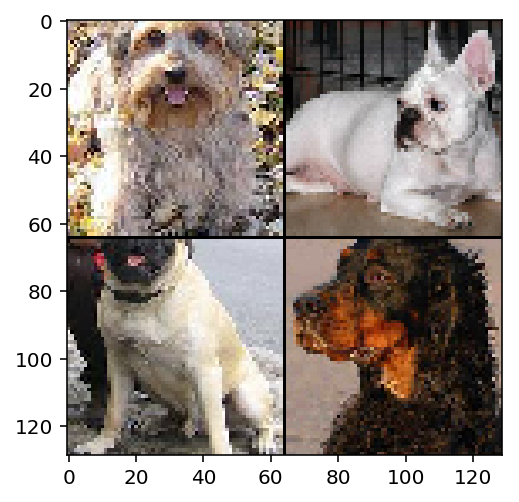

index:111, name: silky_terrier, split data count: 6
index:114, name: french_bulldog, split data count: 6
index:66, name: bull_mastiff, split data count: 6
index:88, name: gordon_setter, split data count: 6
Trainning sub batch 1/6 in local loss is 4.5204
random sample at 154, 158


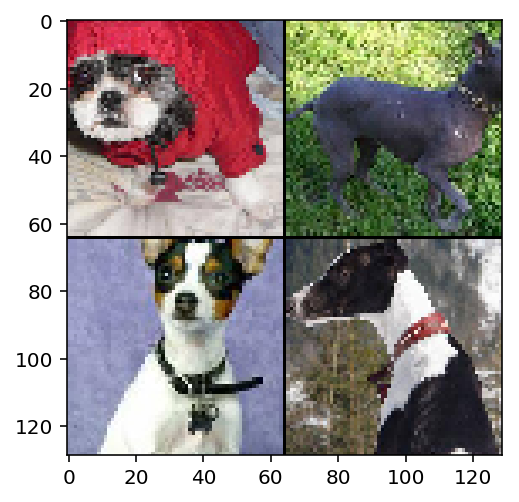

index:36, name: shih-tzu, split data count: 6
index:65, name: mexican_hairless, split data count: 6
index:81, name: toy_terrier, split data count: 6
index:99, name: whippet, split data count: 6
Trainning sub batch 1/6 in local loss is 4.5702
Split summary: Trainning 2/2  in epoch 7, local loss is 4.4883
test random sample at 556, 560


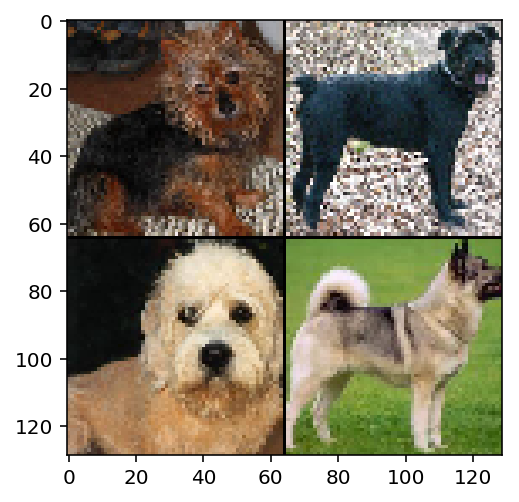

index:42, name: australian_terrier, split data count: 6
index:29, name: giant_schnauzer, split data count: 6
index:93, name: dandie_dinmont, split data count: 6
index:35, name: norwegian_elkhound, split data count: 6
Validation Loss:     4.5707 Validation Accuracy: 0.031370


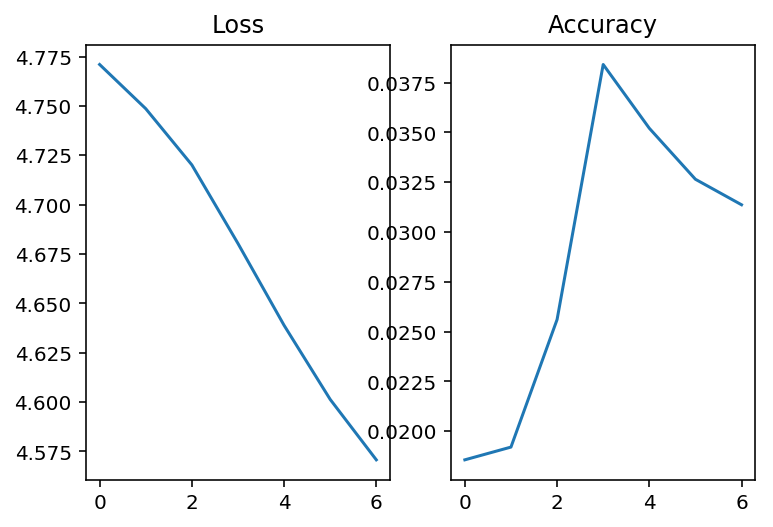

epoch Summary: 2017-12-23 04:55:04.163381: loss = 4.4883 (115.3 examples/sec; 4.442 sec/batch)
----------------------------
random sample at 188, 192


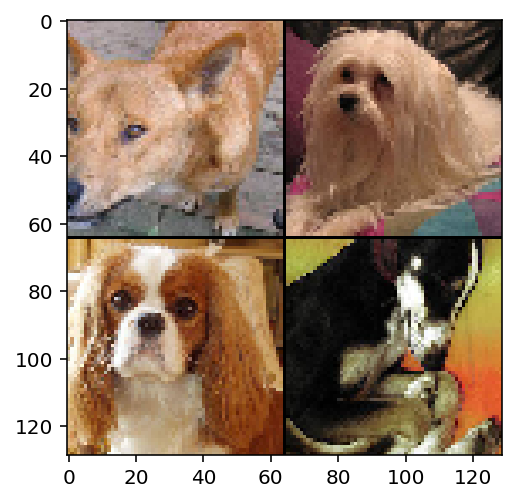

index:1, name: dingo, split data count: 6
index:11, name: maltese_dog, split data count: 6
index:110, name: blenheim_spaniel, split data count: 6
index:99, name: whippet, split data count: 6
Trainning sub batch 1/6 in local loss is 4.4792
random sample at 372, 376


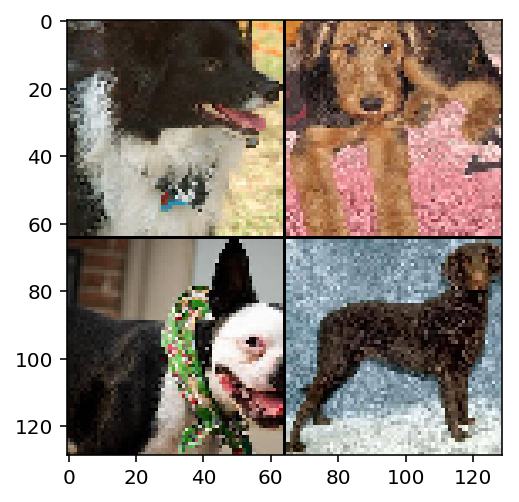

index:52, name: papillon, split data count: 6
index:63, name: airedale, split data count: 6
index:0, name: boston_bull, split data count: 6
index:106, name: curly-coated_retriever, split data count: 6
Trainning sub batch 1/6 in local loss is 4.5389
Split summary: Trainning 2/2  in epoch 8, local loss is 4.4647
test random sample at 1052, 1056


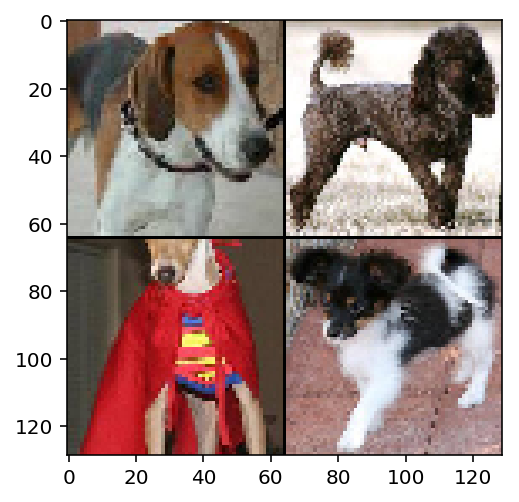

index:87, name: english_foxhound, split data count: 6
index:104, name: miniature_poodle, split data count: 6
index:71, name: italian_greyhound, split data count: 6
index:52, name: papillon, split data count: 6
Validation Loss:     4.5500 Validation Accuracy: 0.030730


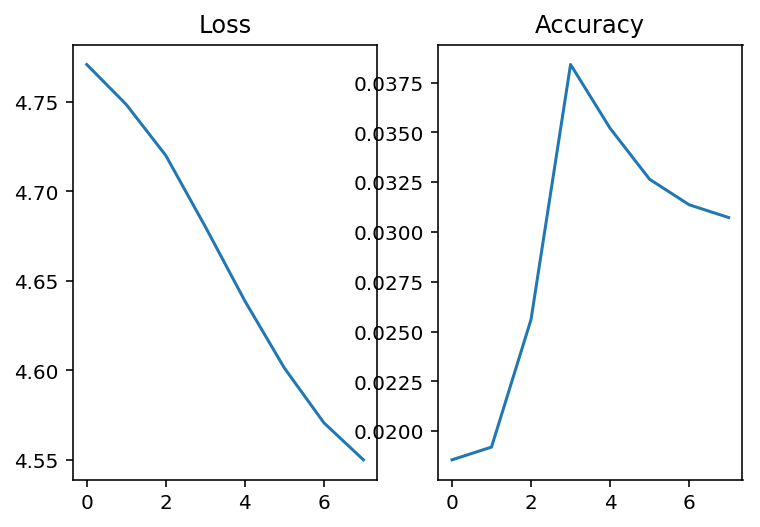

epoch Summary: 2017-12-23 04:55:08.518377: loss = 4.4647 (117.7 examples/sec; 4.349 sec/batch)
----------------------------
random sample at 385, 389


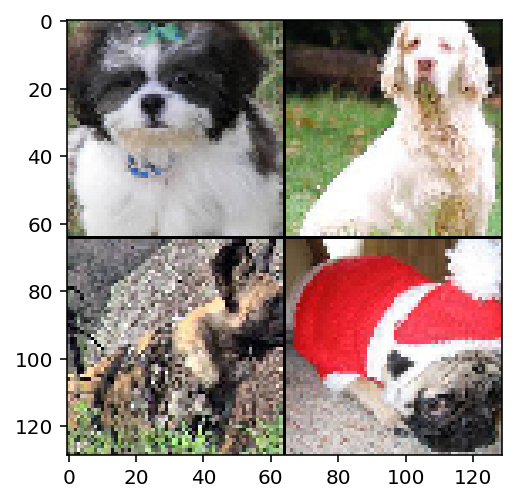

index:36, name: shih-tzu, split data count: 6
index:72, name: clumber, split data count: 6
index:13, name: african_hunting_dog, split data count: 6
index:60, name: pug, split data count: 6
Trainning sub batch 1/6 in local loss is 4.4440
random sample at 469, 473


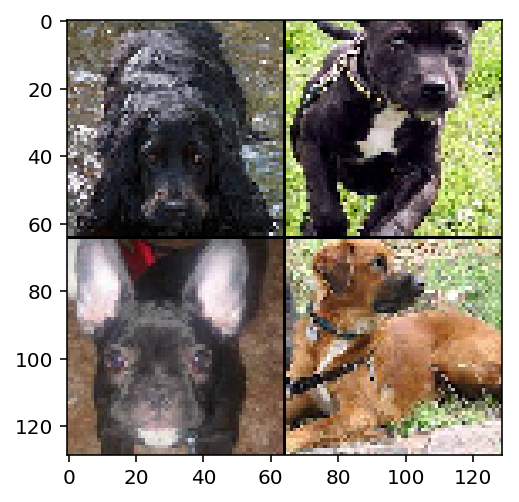

index:118, name: cocker_spaniel, split data count: 6
index:86, name: staffordshire_bullterrier, split data count: 6
index:114, name: french_bulldog, split data count: 6
index:90, name: newfoundland, split data count: 6
Trainning sub batch 1/6 in local loss is 4.5139
Split summary: Trainning 2/2  in epoch 9, local loss is 4.4411
test random sample at 1281, 1285


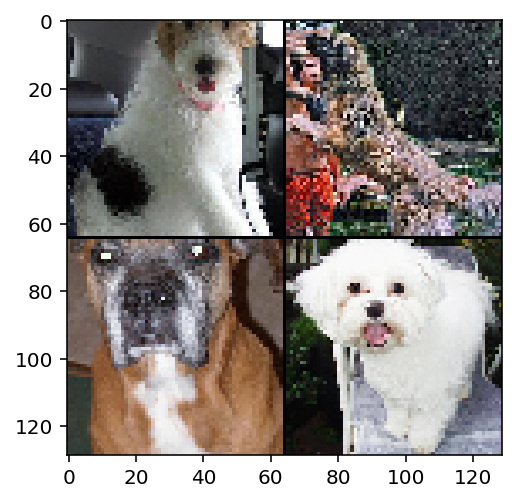

index:14, name: wire-haired_fox_terrier, split data count: 6
index:64, name: leonberg, split data count: 6
index:17, name: boxer, split data count: 6
index:11, name: maltese_dog, split data count: 6
Validation Loss:     4.5339 Validation Accuracy: 0.030730


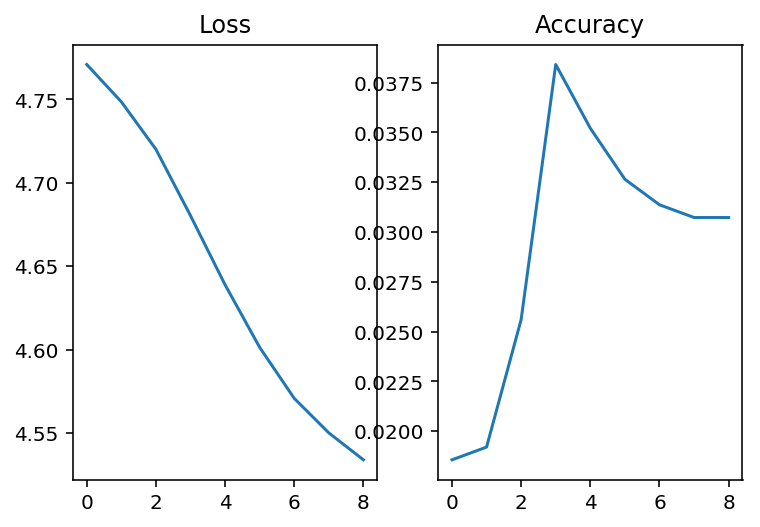

epoch Summary: 2017-12-23 04:55:12.845896: loss = 4.4411 (118.4 examples/sec; 4.324 sec/batch)
----------------------------
random sample at 198, 202


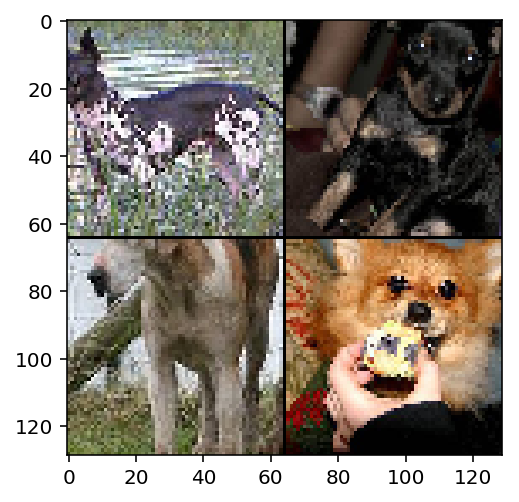

index:65, name: mexican_hairless, split data count: 6
index:77, name: miniature_pinscher, split data count: 6
index:87, name: english_foxhound, split data count: 6
index:105, name: pomeranian, split data count: 6
Trainning sub batch 1/6 in local loss is 4.4163
random sample at 381, 385


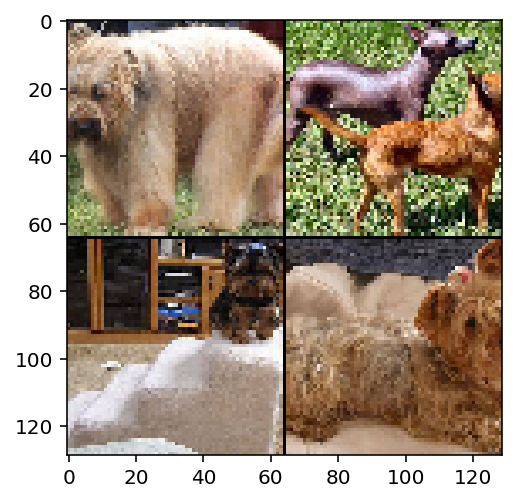

index:91, name: briard, split data count: 6
index:65, name: mexican_hairless, split data count: 6
index:107, name: yorkshire_terrier, split data count: 6
index:107, name: yorkshire_terrier, split data count: 6
Trainning sub batch 1/6 in local loss is 4.4968
Split summary: Trainning 2/2  in epoch 10, local loss is 4.4299
test random sample at 796, 800


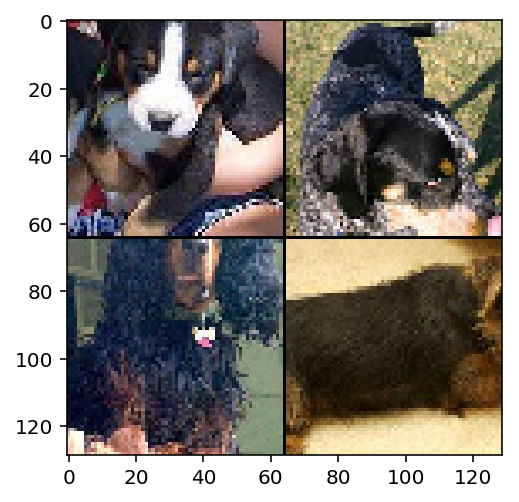

index:40, name: greater_swiss_mountain_dog, split data count: 6
index:3, name: bluetick, split data count: 6
index:88, name: gordon_setter, split data count: 6
index:12, name: norfolk_terrier, split data count: 6
Validation Loss:     4.5267 Validation Accuracy: 0.029449


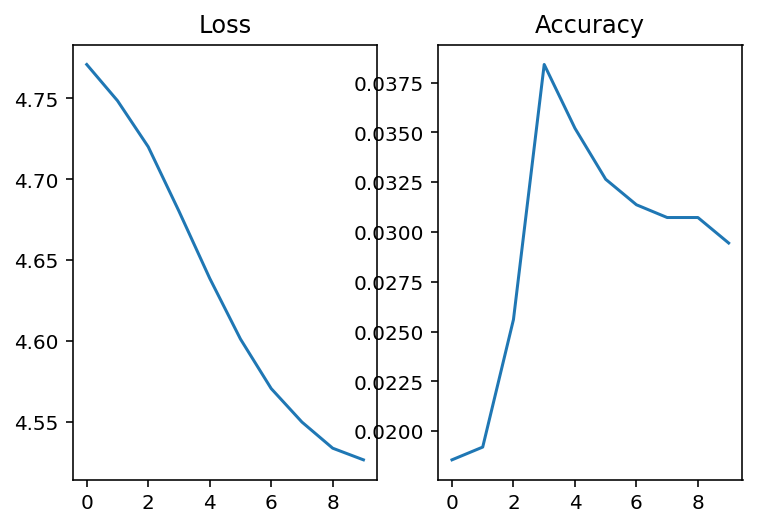

epoch Summary: 2017-12-23 04:55:17.231838: loss = 4.4299 (116.9 examples/sec; 4.381 sec/batch)
----------------------------
random sample at 78, 82


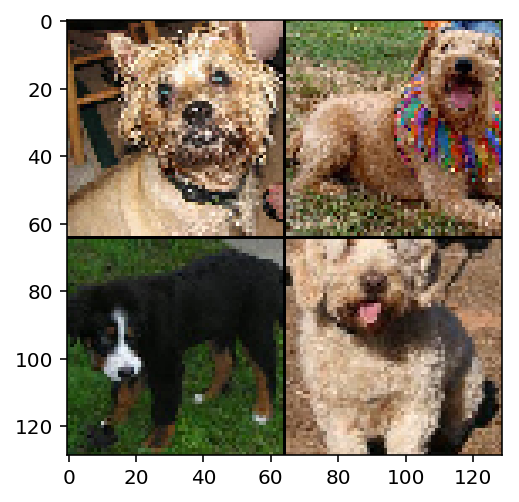

index:23, name: cairn, split data count: 6
index:37, name: irish_terrier, split data count: 6
index:67, name: bernese_mountain_dog, split data count: 6
index:93, name: dandie_dinmont, split data count: 6
Trainning sub batch 1/6 in local loss is 4.3968
random sample at 410, 414


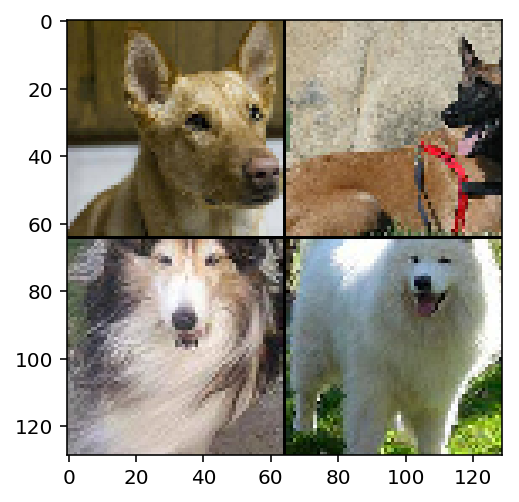

index:1, name: dingo, split data count: 6
index:61, name: malinois, split data count: 6
index:55, name: collie, split data count: 6
index:48, name: samoyed, split data count: 6
Trainning sub batch 1/6 in local loss is 4.4878
Split summary: Trainning 2/2  in epoch 11, local loss is 4.4228
test random sample at 1092, 1096


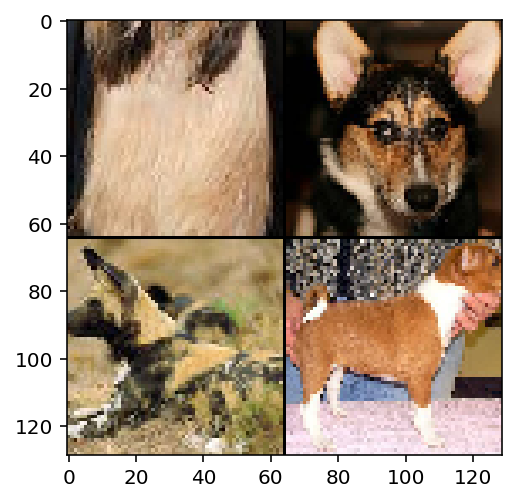

index:74, name: afghan_hound, split data count: 6
index:108, name: pembroke, split data count: 6
index:13, name: african_hunting_dog, split data count: 6
index:7, name: basenji, split data count: 6
Validation Loss:     4.5229 Validation Accuracy: 0.033931


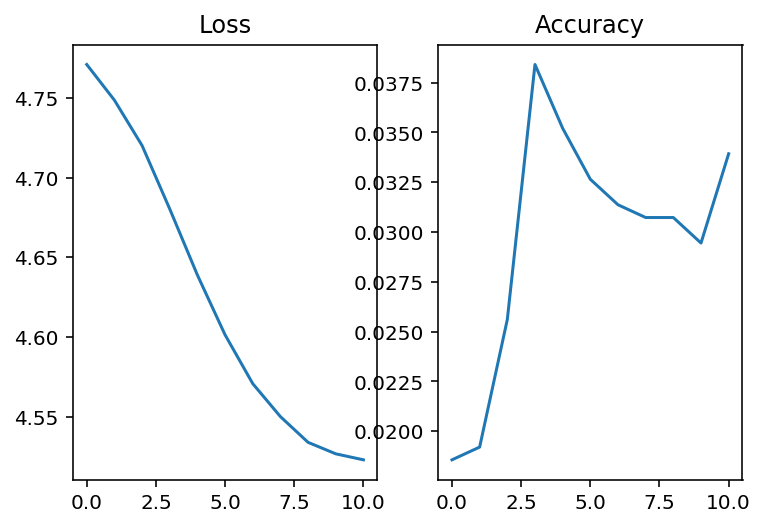

epoch Summary: 2017-12-23 04:55:21.606542: loss = 4.4228 (117.1 examples/sec; 4.371 sec/batch)
----------------------------
random sample at 103, 107


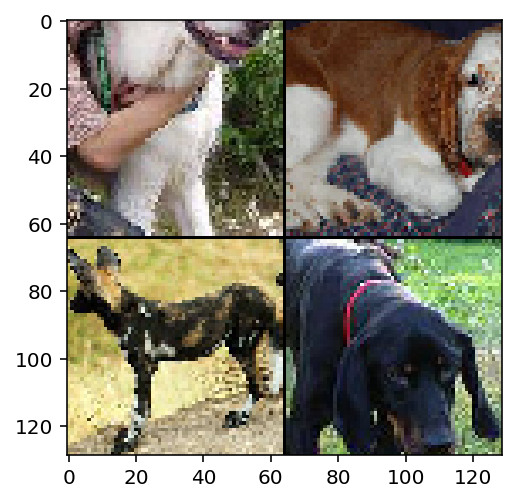

index:94, name: great_pyrenees, split data count: 6
index:57, name: welsh_springer_spaniel, split data count: 6
index:13, name: african_hunting_dog, split data count: 6
index:22, name: black-and-tan_coonhound, split data count: 6
Trainning sub batch 1/6 in local loss is 4.3836
random sample at 271, 275


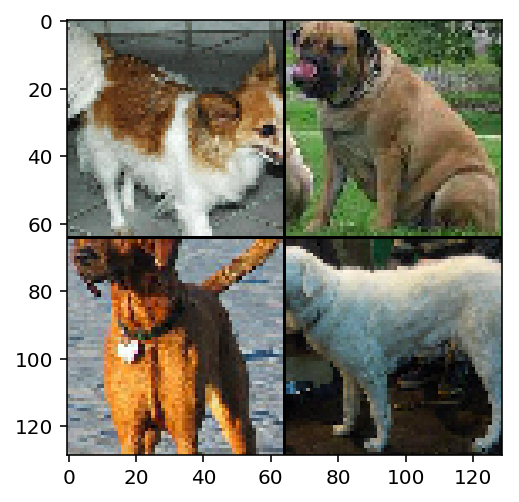

index:52, name: papillon, split data count: 6
index:66, name: bull_mastiff, split data count: 6
index:15, name: redbone, split data count: 6
index:38, name: kuvasz, split data count: 6
Trainning sub batch 1/6 in local loss is 4.4798
Split summary: Trainning 2/2  in epoch 12, local loss is 4.4154
test random sample at 1099, 1103


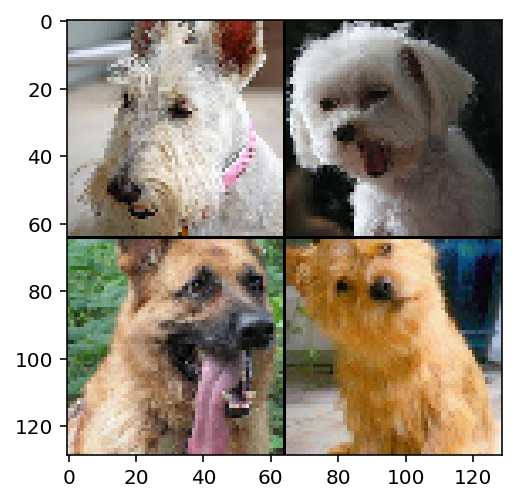

index:73, name: scotch_terrier, split data count: 6
index:11, name: maltese_dog, split data count: 6
index:39, name: german_shepherd, split data count: 6
index:84, name: norwich_terrier, split data count: 6
Validation Loss:     4.5196 Validation Accuracy: 0.035211


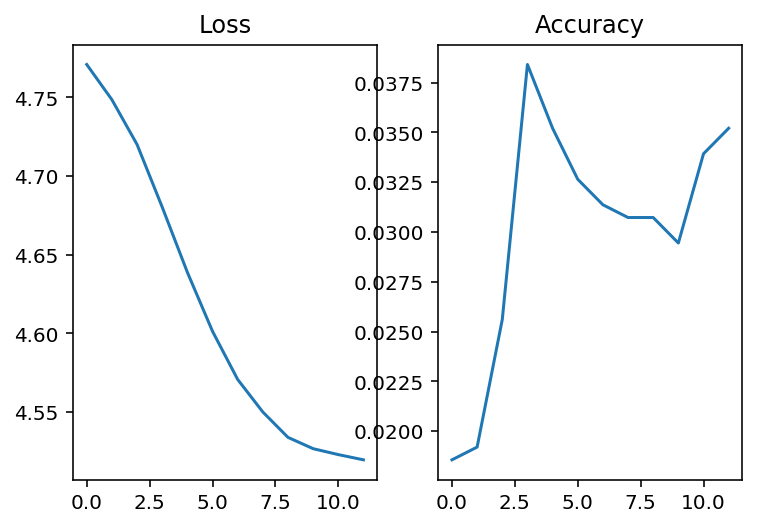

epoch Summary: 2017-12-23 04:55:26.064910: loss = 4.4154 (114.9 examples/sec; 4.455 sec/batch)
----------------------------
random sample at 243, 247


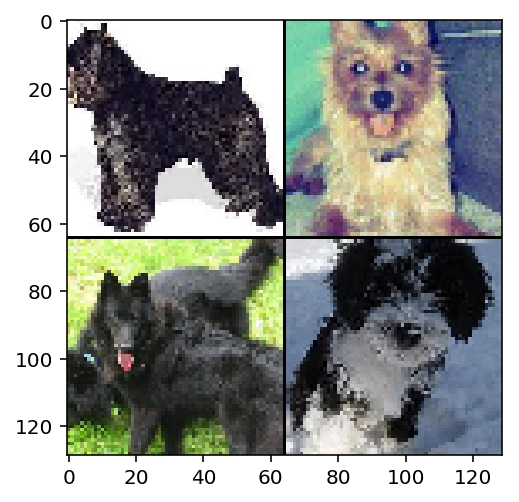

index:115, name: bouvier_des_flandres, split data count: 6
index:42, name: australian_terrier, split data count: 6
index:30, name: groenendael, split data count: 6
index:34, name: tibetan_terrier, split data count: 6
Trainning sub batch 1/6 in local loss is 4.3732
random sample at 317, 321


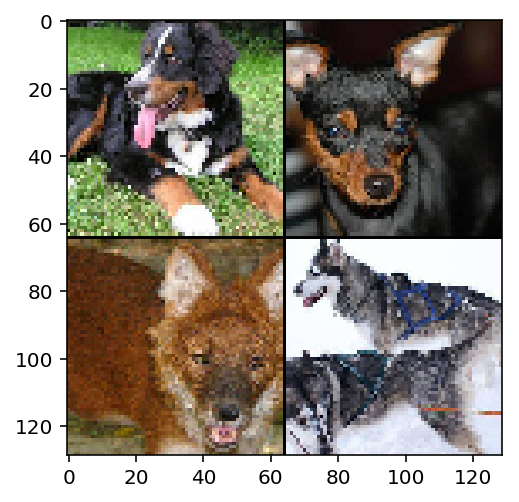

index:67, name: bernese_mountain_dog, split data count: 6
index:77, name: miniature_pinscher, split data count: 6
index:31, name: dhole, split data count: 6
index:89, name: siberian_husky, split data count: 6
Trainning sub batch 1/6 in local loss is 4.4720
Split summary: Trainning 2/2  in epoch 13, local loss is 4.4080
test random sample at 469, 473


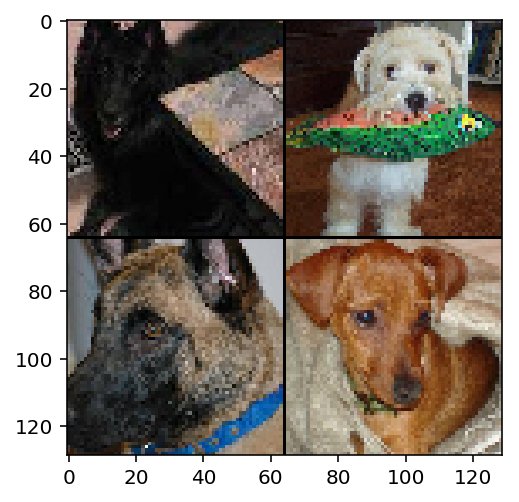

index:30, name: groenendael, split data count: 6
index:11, name: maltese_dog, split data count: 6
index:61, name: malinois, split data count: 6
index:77, name: miniature_pinscher, split data count: 6
Validation Loss:     4.5135 Validation Accuracy: 0.038412


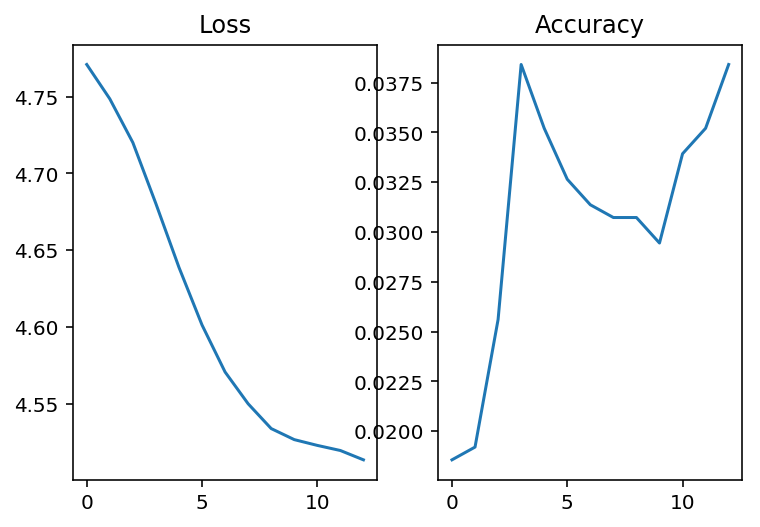

epoch Summary: 2017-12-23 04:55:30.451403: loss = 4.4080 (116.9 examples/sec; 4.381 sec/batch)
----------------------------
random sample at 313, 317


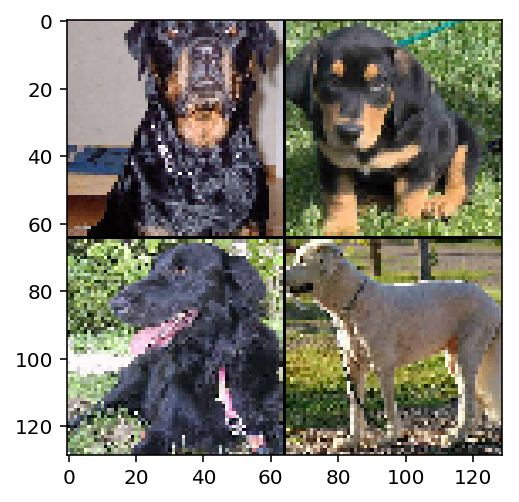

index:119, name: rottweiler, split data count: 6
index:22, name: black-and-tan_coonhound, split data count: 6
index:83, name: flat-coated_retriever, split data count: 6
index:94, name: great_pyrenees, split data count: 6
Trainning sub batch 1/6 in local loss is 4.3656
random sample at 154, 158


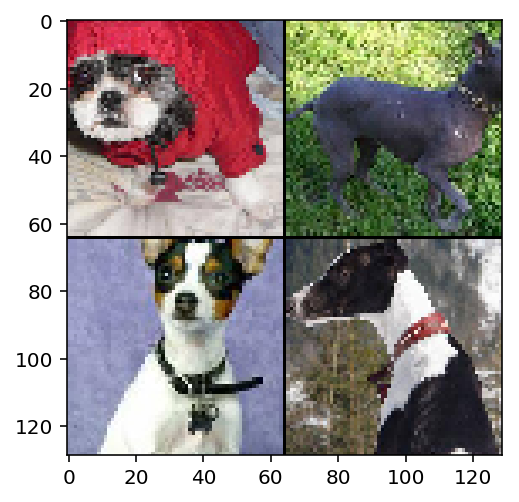

index:36, name: shih-tzu, split data count: 6
index:65, name: mexican_hairless, split data count: 6
index:81, name: toy_terrier, split data count: 6
index:99, name: whippet, split data count: 6
Trainning sub batch 1/6 in local loss is 4.4650
Split summary: Trainning 2/2  in epoch 14, local loss is 4.4017
test random sample at 1290, 1294


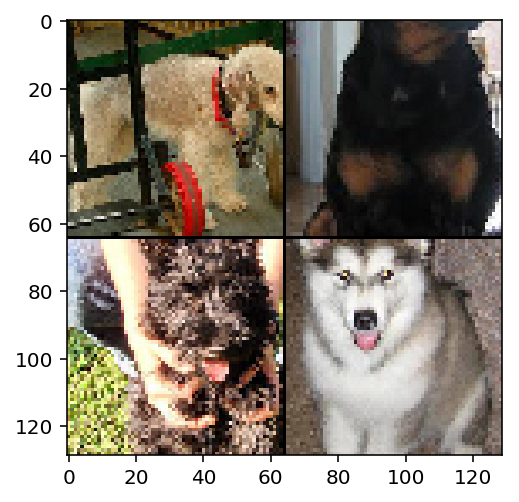

index:5, name: bedlington_terrier, split data count: 6
index:77, name: miniature_pinscher, split data count: 6
index:73, name: scotch_terrier, split data count: 6
index:56, name: malamute, split data count: 6
Validation Loss:     4.5099 Validation Accuracy: 0.038412


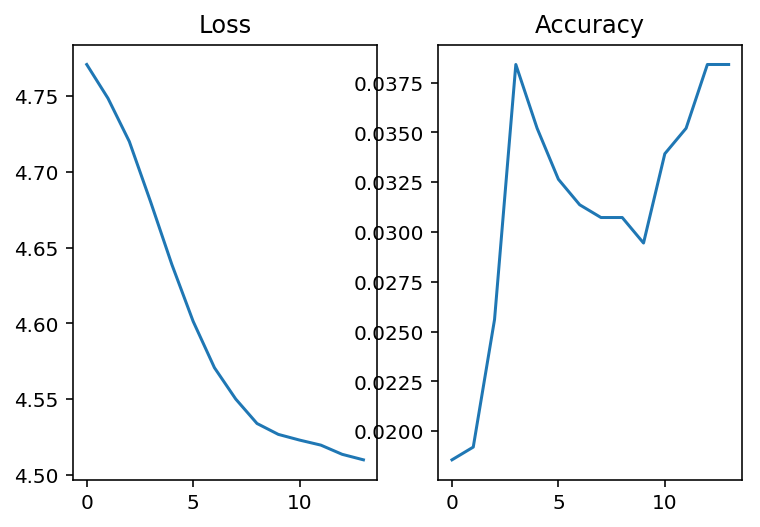

epoch Summary: 2017-12-23 04:55:35.126348: loss = 4.4017 (109.6 examples/sec; 4.671 sec/batch)
----------------------------
random sample at 75, 79


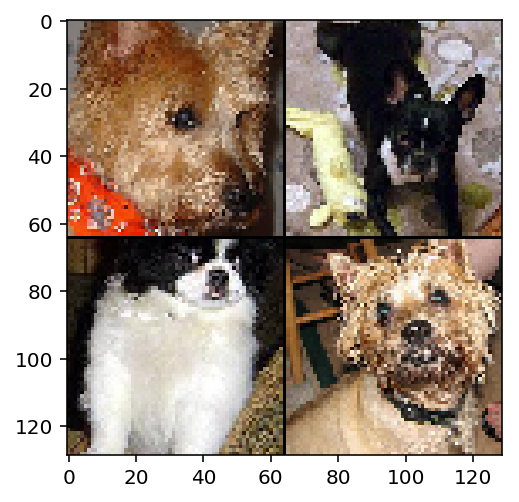

index:23, name: cairn, split data count: 6
index:0, name: boston_bull, split data count: 6
index:103, name: japanese_spaniel, split data count: 6
index:23, name: cairn, split data count: 6
Trainning sub batch 1/6 in local loss is 4.3595
random sample at 2, 6


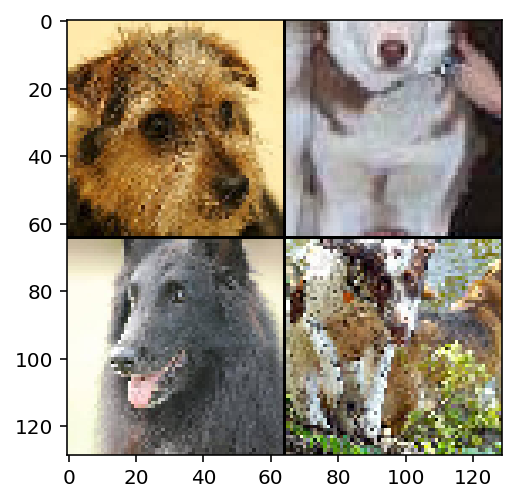

index:12, name: norfolk_terrier, split data count: 6
index:89, name: siberian_husky, split data count: 6
index:30, name: groenendael, split data count: 6
index:113, name: german_short-haired_pointer, split data count: 6
Trainning sub batch 1/6 in local loss is 4.4613
Split summary: Trainning 2/2  in epoch 15, local loss is 4.3946
test random sample at 262, 266


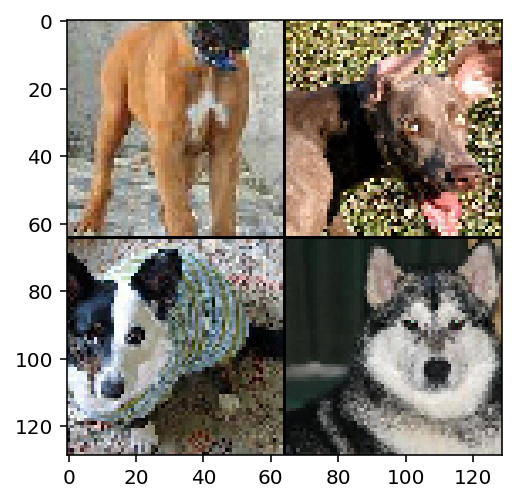

index:17, name: boxer, split data count: 6
index:28, name: weimaraner, split data count: 6
index:70, name: cardigan, split data count: 6
index:56, name: malamute, split data count: 6
Validation Loss:     4.5059 Validation Accuracy: 0.039053


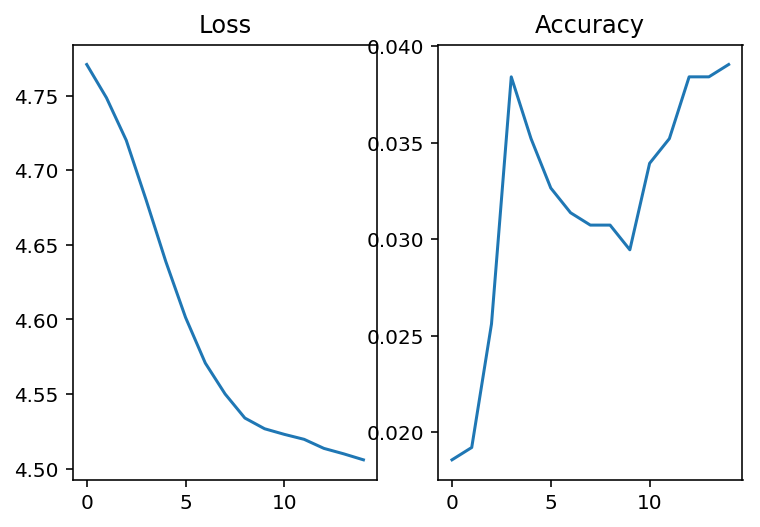

epoch Summary: 2017-12-23 04:55:39.612248: loss = 4.3946 (114.2 examples/sec; 4.482 sec/batch)
----------------------------
random sample at 327, 331


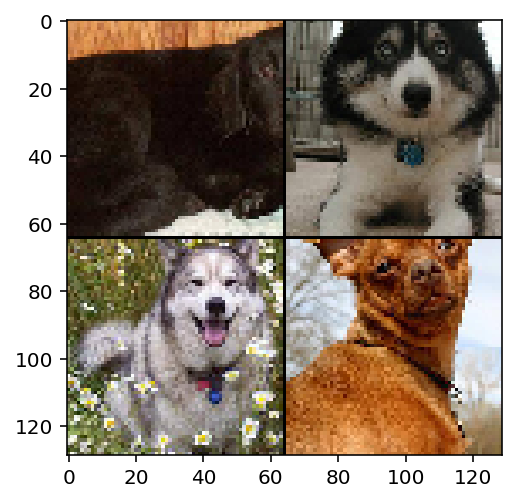

index:83, name: flat-coated_retriever, split data count: 6
index:89, name: siberian_husky, split data count: 6
index:56, name: malamute, split data count: 6
index:77, name: miniature_pinscher, split data count: 6
Trainning sub batch 1/6 in local loss is 4.3542
random sample at 447, 451


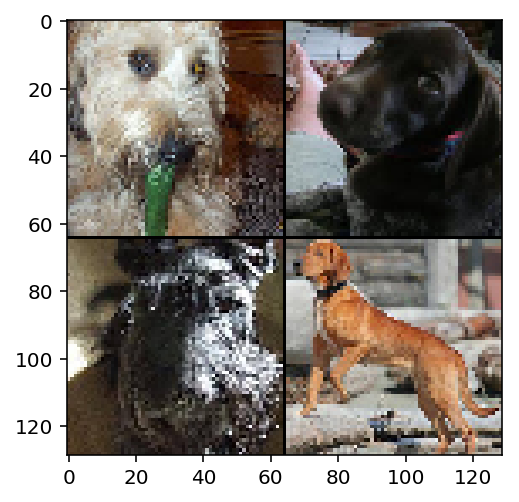

index:85, name: soft-coated_wheaten_terrier, split data count: 6
index:113, name: german_short-haired_pointer, split data count: 6
index:73, name: scotch_terrier, split data count: 6
index:15, name: redbone, split data count: 6
Trainning sub batch 1/6 in local loss is 4.4537
Split summary: Trainning 2/2  in epoch 16, local loss is 4.3907
test random sample at 56, 60


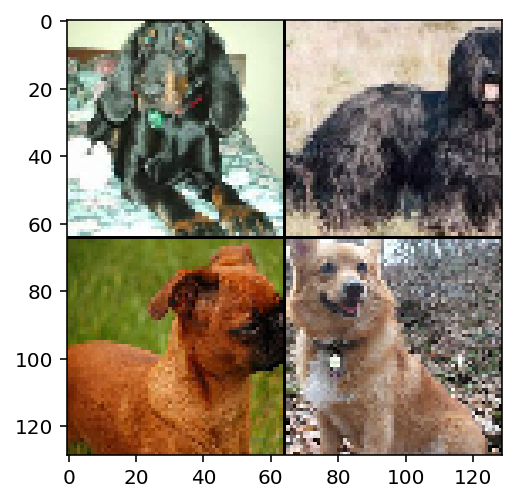

index:22, name: black-and-tan_coonhound, split data count: 6
index:91, name: briard, split data count: 6
index:80, name: brabancon_griffon, split data count: 6
index:108, name: pembroke, split data count: 6
Validation Loss:     4.5027 Validation Accuracy: 0.040333


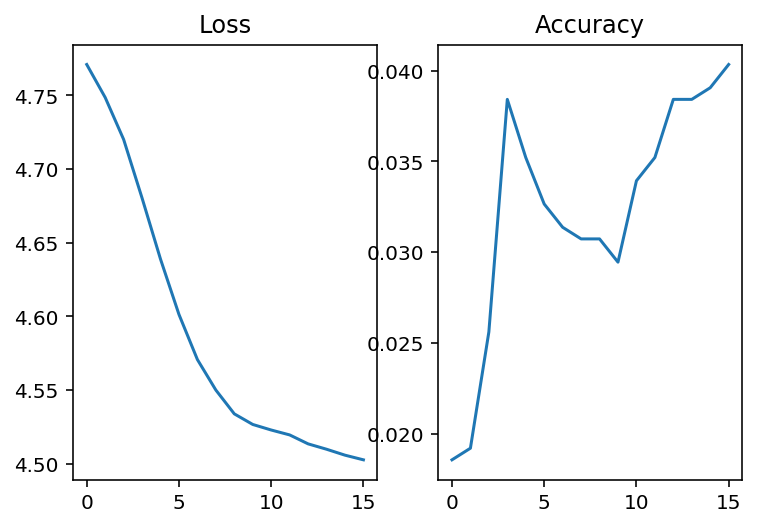

epoch Summary: 2017-12-23 04:55:43.945932: loss = 4.3907 (118.3 examples/sec; 4.329 sec/batch)
----------------------------
random sample at 15, 19


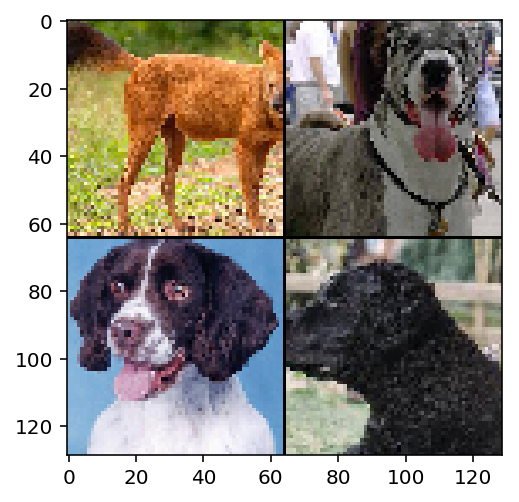

index:31, name: dhole, split data count: 6
index:109, name: great_dane, split data count: 6
index:117, name: english_springer, split data count: 6
index:106, name: curly-coated_retriever, split data count: 6
Trainning sub batch 1/6 in local loss is 4.3496
random sample at 241, 245


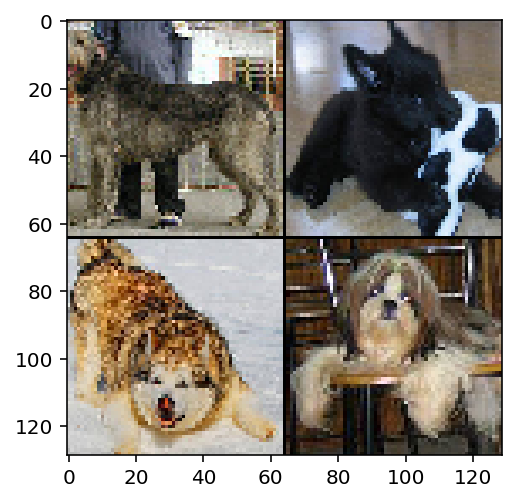

index:8, name: scottish_deerhound, split data count: 6
index:30, name: groenendael, split data count: 6
index:56, name: malamute, split data count: 6
index:36, name: shih-tzu, split data count: 6
Trainning sub batch 1/6 in local loss is 4.4507
Split summary: Trainning 2/2  in epoch 17, local loss is 4.3843
test random sample at 158, 162


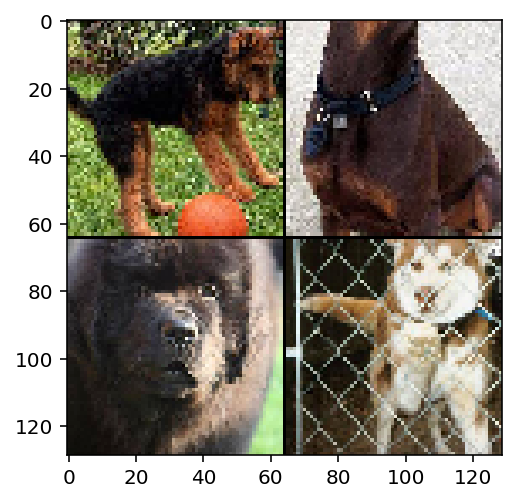

index:63, name: airedale, split data count: 6
index:18, name: doberman, split data count: 6
index:90, name: newfoundland, split data count: 6
index:89, name: siberian_husky, split data count: 6
Validation Loss:     4.4991 Validation Accuracy: 0.040333


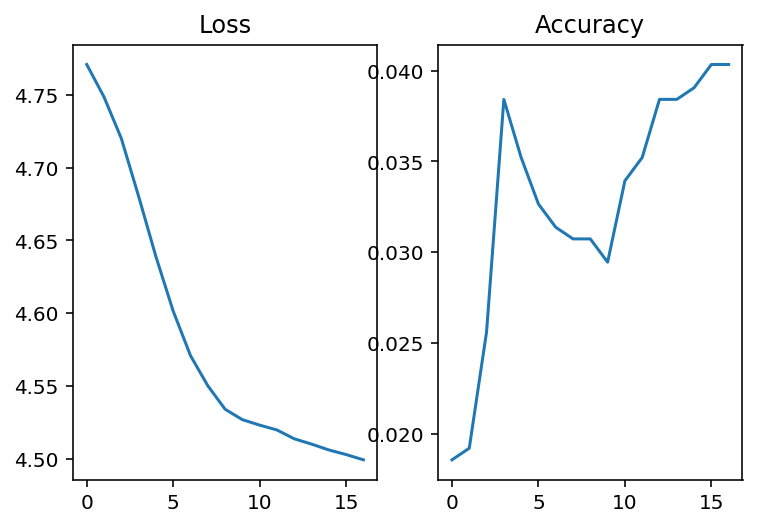

epoch Summary: 2017-12-23 04:55:48.285686: loss = 4.3843 (118.1 examples/sec; 4.335 sec/batch)
----------------------------
random sample at 389, 393


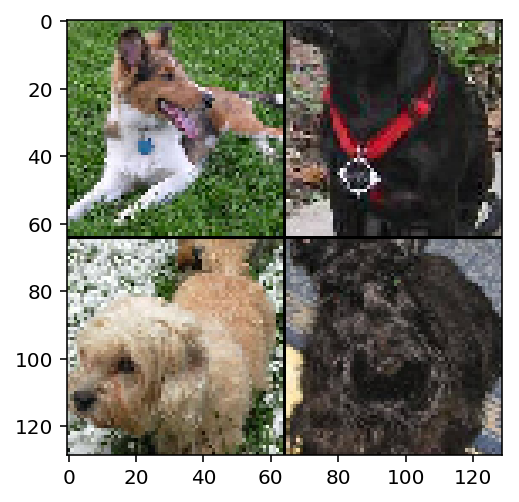

index:9, name: shetland_sheepdog, split data count: 6
index:80, name: brabancon_griffon, split data count: 6
index:93, name: dandie_dinmont, split data count: 6
index:73, name: scotch_terrier, split data count: 6
Trainning sub batch 1/6 in local loss is 4.3452
random sample at 129, 133


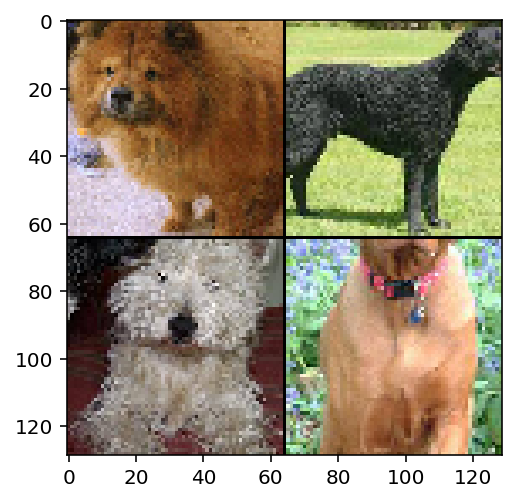

index:82, name: chow, split data count: 6
index:106, name: curly-coated_retriever, split data count: 6
index:97, name: west_highland_white_terrier, split data count: 6
index:96, name: vizsla, split data count: 6
Trainning sub batch 1/6 in local loss is 4.4451
Split summary: Trainning 2/2  in epoch 18, local loss is 4.3785
test random sample at 196, 200


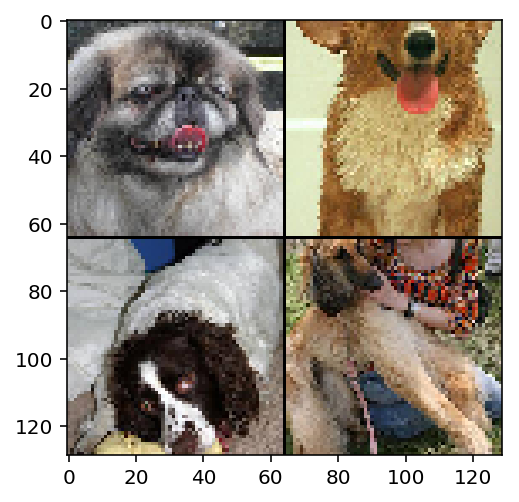

index:2, name: pekinese, split data count: 6
index:108, name: pembroke, split data count: 6
index:117, name: english_springer, split data count: 6
index:74, name: afghan_hound, split data count: 6
Validation Loss:     4.4949 Validation Accuracy: 0.042254


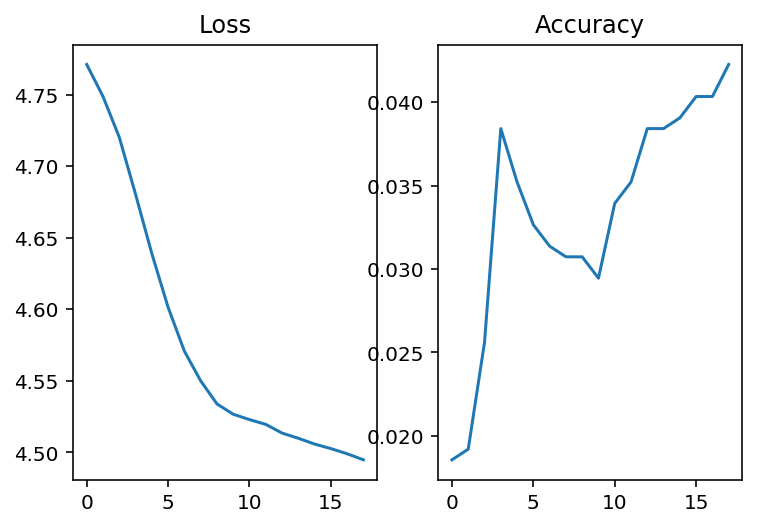

epoch Summary: 2017-12-23 04:55:52.726546: loss = 4.3785 (115.4 examples/sec; 4.438 sec/batch)
----------------------------
random sample at 380, 384


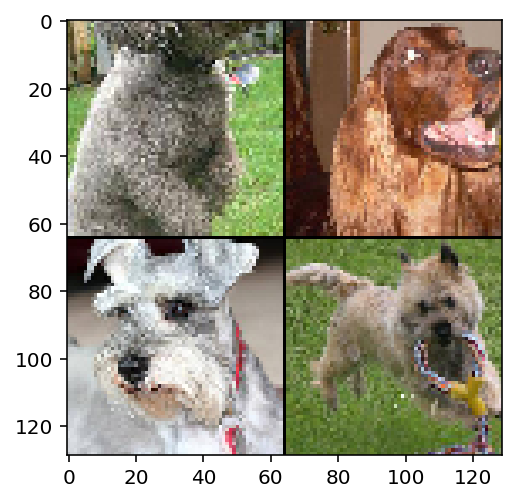

index:104, name: miniature_poodle, split data count: 6
index:45, name: irish_setter, split data count: 6
index:49, name: miniature_schnauzer, split data count: 6
index:23, name: cairn, split data count: 6
Trainning sub batch 1/6 in local loss is 4.3408
random sample at 141, 145


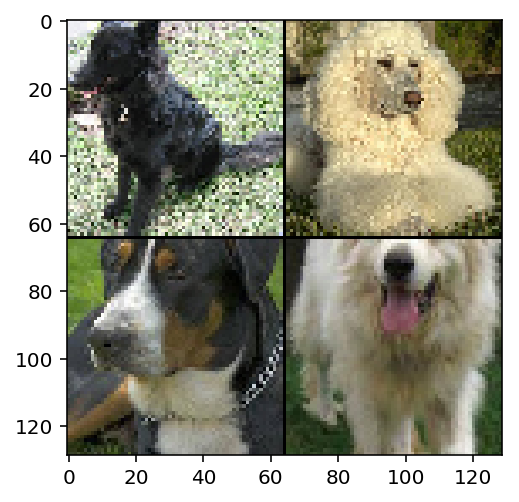

index:30, name: groenendael, split data count: 6
index:101, name: standard_poodle, split data count: 6
index:40, name: greater_swiss_mountain_dog, split data count: 6
index:94, name: great_pyrenees, split data count: 6
Trainning sub batch 1/6 in local loss is 4.4399
Split summary: Trainning 2/2  in epoch 19, local loss is 4.3729
test random sample at 1076, 1080


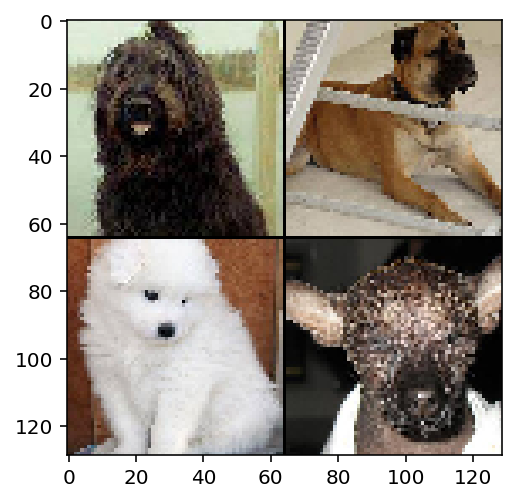

index:91, name: briard, split data count: 6
index:66, name: bull_mastiff, split data count: 6
index:48, name: samoyed, split data count: 6
index:65, name: mexican_hairless, split data count: 6
Validation Loss:     4.4908 Validation Accuracy: 0.044174


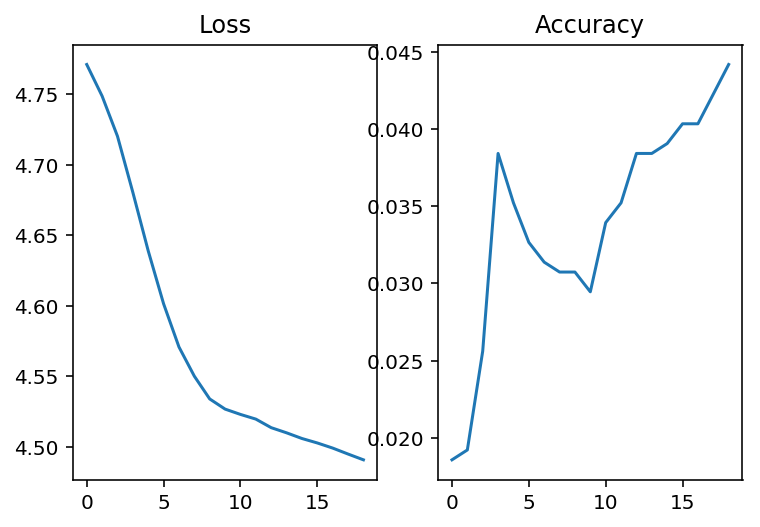

epoch Summary: 2017-12-23 04:55:57.094620: loss = 4.3729 (117.3 examples/sec; 4.363 sec/batch)
----------------------------
random sample at 310, 314


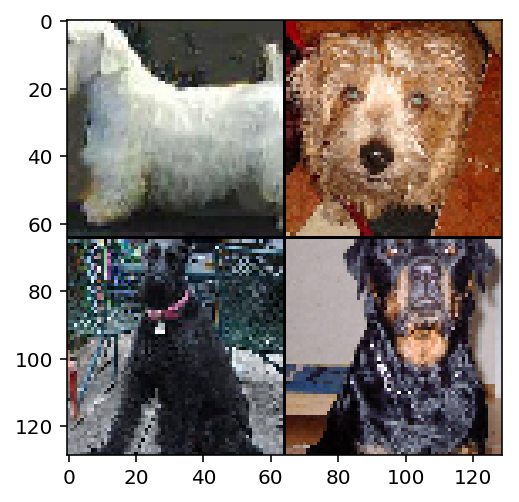

index:100, name: sealyham_terrier, split data count: 6
index:12, name: norfolk_terrier, split data count: 6
index:29, name: giant_schnauzer, split data count: 6
index:119, name: rottweiler, split data count: 6
Trainning sub batch 1/6 in local loss is 4.3363


KeyboardInterrupt: 

In [18]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(tf.global_variables())
    summary_op = tf.summary.merge_all()
    writer = tf.summary.FileWriter("./NoTran_Test",sess.graph)
    Losses, Accuracies = [], []
    
    for i in range(epochs):
        epoch = i
        start_time = time.time()
        TotalDataCount = 0
        for _n_split in range (n_split):
            batch_i = 0
            dataCount = [{}]
            x_t, y_t = None, None
            features, labels = None, None
            gc.collect()
            features, labels = pickle.load(open('./preprocess_batch_trainning_{}.p'.format(_n_split), mode='rb'))
            trainBatchCount = int(features.shape[0] / batch_size)
            for x_t, y_t, batch_i in BatchingData(batch_size, features, labels, trainBatchCount):
                if batch_i == 0:
                    istart = rand.randint(0, x_t.shape[0] - 5)
                    iend = istart+4
                    print('random sample at {}, {}'.format(istart, iend))
                    view_images(x_t[istart:iend])
                    _dcoded = OnehotDecode(y_t[istart:iend])
                    for lab_ in _dcoded:
                        print('index:{}, name: {}, split data count: {}'.format(lab_, Lstrings[int(lab_)], trainBatchCount))

                _, train_loss_value, = sess.run([train_op, full_loss], {x:x_t, y:y_t, keep_prob:keep_probability, learning_rate:learningRate})
                    
                if batch_i % 10 == 0:
                    print('Trainning sub batch {}/{} in local loss is {:.4f}'.format(batch_i+1, trainBatchCount,train_loss_value))
                
                if batch_i == trainBatchCount-1 and _n_split == n_split-1:
                    print('Split summary: Trainning {}/{}  in epoch {}, local loss is {:.4f}'.format(_n_split+1, n_split, 
                                                                                         epoch+1, train_loss_value))
                    _loss, _acc = print_stats(sess, x_t, y_t, full_loss, accuracy)
                    Losses.append(_loss)
                    Accuracies.append(_acc)
                    
                    plot.subplot2grid((1,2),(0,0))
                    plot.title(u"Loss") # 标题
                    plot.plot(Losses)


                    plot.subplot2grid((1,2),(0,1))
                    plot.title(u"Accuracy") # 标题
                    plot.plot(Accuracies)
                    plot.show()
                    
                    summary_str = sess.run(summary_op, feed_dict={x:x_t, y:y_t, keep_prob:1., learning_rate:learningRate})
                    
                    
            
            
            #thetas = sess.run(h_trans2, feed_dict={x:x_t, keep_prob:1.})
            #view_images(thetas[0:9])
            #TotalDataCount += dataCount[0]
        x_t = None
        y_t = None
        if epoch % 50 == 0 and epoch > 5:
            writer.add_summary(summary_str, epoch)
            writer.flush()
        duration = time.time() - start_time
        examples_per_sec = batch_size / duration
        format_str = ('epoch Summary: {}: loss = {:.4f} ({:.1f} examples/sec; {:.3f} ' 'sec/batch)')
        print (format_str.format(datetime.now(), train_loss_value, examples_per_sec, duration))
        print ('----------------------------')
        
        
        """
        try:
            if i == 4:
                saveOutput(sess, 5)

            if i == 9:
                saveOutput(sess, 10)

            if i == 14:
                saveOutput(sess, 15)

            if i == 24:
                saveOutput(sess, 15)
        except Exception as e3:
            pass
        """
        
        
        
        

In [13]:
import pandas
from sklearn import preprocessing

with open('./prediction_whole_v2.p', 'rb') as f:
    dictarr = pickle.load(f)
tab_Name = [] 
for item in dictarr['tab_Name']:
    name = item
    name = (item.split('-')[1:])
    tag = name[0]
    if len(name) > 1:
        for n in name[1:]:
            tag = tag+'-'+n
    tab_Name.append(tag)
    
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(dictarr['predictions'])
print(data)
df = pandas.DataFrame(data, index=dictarr['names'], columns=tab_Name)
df.to_csv('./whole_v2.csv')

[[ 0.21446006  0.94688982  0.28981623 ...,  0.1290572   0.12192369
   0.08081654]
 [ 0.12934476  0.24568164  0.28317022 ...,  0.21828833  0.15518899
   0.09823251]
 [ 0.10288711  0.22131793  0.18747266 ...,  0.12819931  0.0940453
   0.13214342]
 ..., 
 [ 0.18254815  0.17949283  0.16126163 ...,  0.55048567  0.86190015
   0.40963802]
 [ 0.18584995  0.2632274   0.50773406 ...,  0.15002558  0.14802337
   0.1040114 ]
 [ 0.11952609  0.09833895  0.08640937 ...,  0.16867743  0.11383095
   0.19698071]]


In [4]:
n = 'n02085620-chihuahua'
name = n.split('-')
print(name)

['n02085620', 'chihuahua']


In [11]:
from datetime import *
import json

def GetTimeStamp(Start, End):
    print('{}, {}'.format(Start, End))
    _number = 0
    temp = 0
    for i in range(End - Start):
        m = (1 << i)
        temp = temp + m
    print(temp)
    _number = (temp << (48 - End))
    print(_number)
    return '{0:b}'.format(_number).zfill(48)

def GetWeeklyTimeSlot():
    timestamps = []
    for i in range(7):
        stamp = {}
        dag = datetime.now() + timedelta(days=i)
        hour = dag.hour * 2 if dag.minute < 30 else dag.hour * 2 + 1
        if i == 0:
            timestamp = GetTimeStamp(48, 48)
        elif i == 1:
            timestamp = GetTimeStamp(hour, 48)
        else:
            timestamp = GetTimeStamp(0, 48)
        stamp['date'] = dag.strftime("%Y-%m-%d")
        stamp['timeslot'] = timestamp
        timestamps.append(stamp)
    return timestamps

jsonBody = {"code":"0", "msg":"success"}
jsonBody["body"] = {'timeList': GetWeeklyTimeSlot()}
json.dumps(jsonBody)

48, 48
0
0
32, 48
65535
65535
0, 48
281474976710655
281474976710655
0, 48
281474976710655
281474976710655
0, 48
281474976710655
281474976710655
0, 48
281474976710655
281474976710655
0, 48
281474976710655
281474976710655


'{"code": "0", "msg": "success", "body": {"timeList": [{"date": "2018-01-08", "timeslot": "000000000000000000000000000000000000000000000000"}, {"date": "2018-01-09", "timeslot": "000000000000000000000000000000001111111111111111"}, {"date": "2018-01-10", "timeslot": "111111111111111111111111111111111111111111111111"}, {"date": "2018-01-11", "timeslot": "111111111111111111111111111111111111111111111111"}, {"date": "2018-01-12", "timeslot": "111111111111111111111111111111111111111111111111"}, {"date": "2018-01-13", "timeslot": "111111111111111111111111111111111111111111111111"}, {"date": "2018-01-14", "timeslot": "111111111111111111111111111111111111111111111111"}]}}'

In [ ]:
1111111111111111111111111111111111111111
000000000000000000000000000000000001099511627775